In [3]:
import torch
from torch_geometric.data import Data, DataLoader, Dataset
import torch.nn.functional as F
import random 
import networkx as nx

import numpy as np
from torch_geometric.nn import NNConv
from torch.nn import Linear
from matplotlib import pyplot as plt

In [59]:
def generate_polygon(n, radius=1):
    node_pos = [(radius * np.cos(2 * np.pi * i / n),
                 radius * np.sin(2 * np.pi * i / n)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_randPos(n, radius=1):
    node_pos = [(random.uniform(-1, 1),
                 random.uniform(-1, 1)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_edgelist(size):
    return np.array((i, j) for i in range(size) for j in range(i + 1, size))

def node2edge(node_pos):
    feature_len = node_pos.size()[0]
    edgelist = generate_edgelist(feature_len)
    start = node_features[edgelist[0]]
    end = node_features[edgelist[1]]
    return start, end

def generate_eAttr(G, com_edge_list):
    path_length = dict(nx.all_pairs_shortest_path_length(G))
    max_length = 0
    for source in path_length:
        for target in path_length[source]:
            if path_length[source][target] > max_length:
                max_length = path_length[source][target]
    L = 2/max_length
    K = 1
    edge_attr = []
    for i in com_edge_list:
        d = path_length[i[0]][i[1]]
        l = L * d #l = L * d
        k = K/(d**2) 
        edge_attr.append([l,k])
    out = torch.tensor(edge_attr, dtype=torch.float)
    return out

def generate_graph(size):
    while True:
#         G = nx.binomial_graph(size, random.random(),directed=False)
        G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = NNConv(2, 8, Linear(2, 16))
        self.conv2 = NNConv(8, 8, Linear(2, 64))
        self.conv3 = NNConv(8, 2, Linear(2, 16))
#         self.conv4 = NNConv(16+32+64, 128, Linear(2, (16+32+64)*128))
#         self.conv5 = NNConv(128,2,Linear(2,128*2))
#         self.conv2 = NNConv(16,2,Linear(2,16*2))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = F.relu(self.conv1(x, edge_index, edge_attr))
        x2 = F.relu(self.conv2(x1, edge_index, edge_attr))
        x3 = F.relu(self.conv2(x2, edge_index, edge_attr))
        x4 = F.relu(self.conv2(x3, edge_index, edge_attr))
        x5 = self.conv3(x4, edge_index, edge_attr)
#         x2 = F.relu(self.conv2(x1, edge_index, edge_attr))
#         x3 = F.relu(self.conv3(x2, edge_index, edge_attr))
#         x = torch.cat((x1, x2, x3), dim=1)
        
#         x4 = F.relu(self.conv4(x, edge_index, edge_attr))
#         x5 = F.relu(self.conv5(x4,edge_index,edge_attr))
        return x5

class EnergyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data):
        energy = 0
        offset = 0
        edge_attr = data.edge_attr
        n = data.x.size()[0]
        x = p[offset:offset+n, 0]
        y = p[offset:offset+n, 1]
        offset += n
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        for e, (i, j) in enumerate(generate_edgelist(n)):
            term1 = (x[i] - x[j]) ** 2
            term2 = (y[i] - y[j]) ** 2
            term3 = l[e] ** 2
            term4 = 2 * l[e] * (term1 + term2).sqrt()
            energy += k[e] / 2 * (term1 + term2 + term3 - term4)
        return energy
    
class EnergyLossVectorized(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data):
        edge_attr = data.edge_attr
        start, end = node2edge(p)
        start_x = start[:, 0]
        start_y = start[:, 1]
        end_x = end[:, 0]
        end_y = end[:, 1]
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        term1 = (start_x - end_x) ** 2
        term2 = (start_y - end_y) ** 2
        term3 = l ** 2
        term4 = 2 * l * (term1 + term2).sqrt()
        energy = k / 2 * (term1 + term2 + term3 - term4)
        return energy.sum()
    
    
def train(model, criterion, optimizer,loader):
    model.train()
    loss_all = 0
    for data in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,data)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(data_list)

def evaluate(model,data):
    model.eval()
    with torch.no_grad():
        pred = model(data).detach().cpu().numpy()
    return pred


def graph_vis(G, node_pos, file_name):
    i = 0
    for n, p in node_pos:
        G.nodes[i]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    plt.savefig(file_name) 

0 tensor(1449.8490, grad_fn=<AddBackward0>)
1000 tensor(96.0011, grad_fn=<AddBackward0>)
2000 tensor(4.1241, grad_fn=<AddBackward0>)
3000 tensor(2.4381, grad_fn=<AddBackward0>)
4000 tensor(1.6650, grad_fn=<AddBackward0>)
5000 tensor(1.1925, grad_fn=<AddBackward0>)
6000 tensor(0.9218, grad_fn=<AddBackward0>)
7000 tensor(0.7602, grad_fn=<AddBackward0>)
8000 tensor(0.6415, grad_fn=<AddBackward0>)
9000 tensor(0.5476, grad_fn=<AddBackward0>)
10000 tensor(0.4721, grad_fn=<AddBackward0>)
11000 tensor(0.4121, grad_fn=<AddBackward0>)
12000 tensor(0.3604, grad_fn=<AddBackward0>)
13000 tensor(0.3249, grad_fn=<AddBackward0>)
14000 tensor(0.3141, grad_fn=<AddBackward0>)
15000 tensor(0.3113, grad_fn=<AddBackward0>)
16000 tensor(0.3097, grad_fn=<AddBackward0>)
17000 tensor(0.3088, grad_fn=<AddBackward0>)
18000 tensor(0.3085, grad_fn=<AddBackward0>)
19000 tensor(0.3084, grad_fn=<AddBackward0>)
20000 tensor(0.3084, grad_fn=<AddBackward0>)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

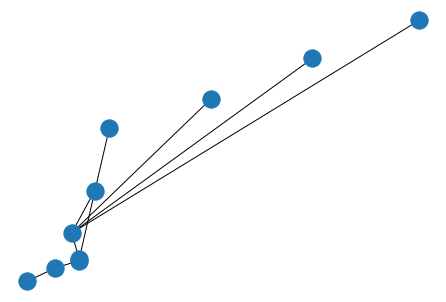

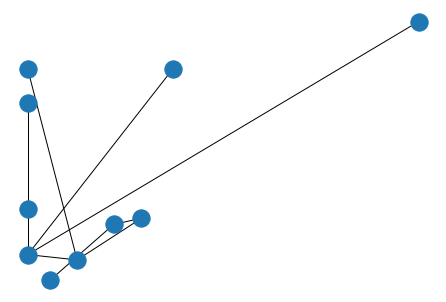

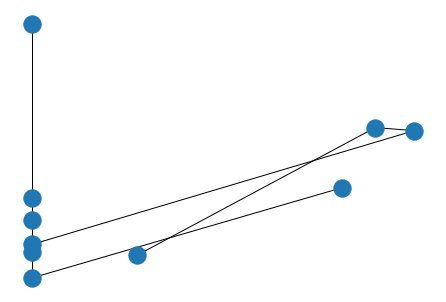

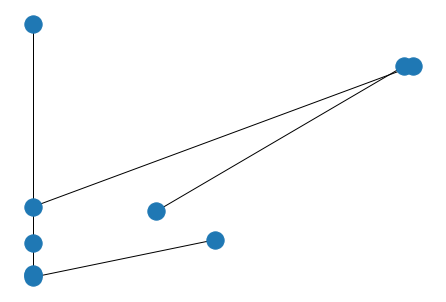

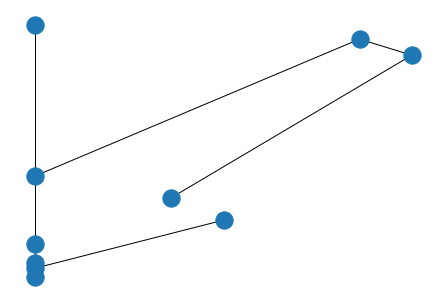

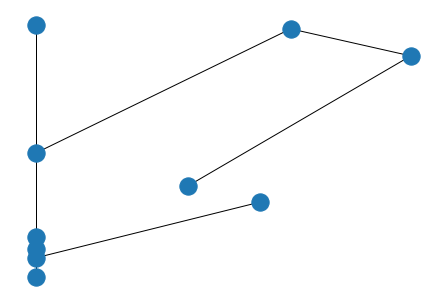

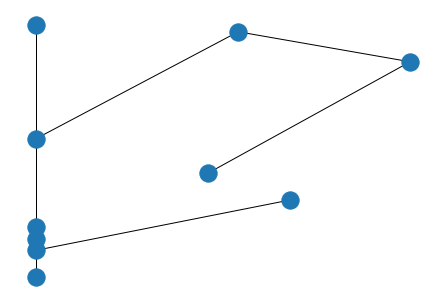

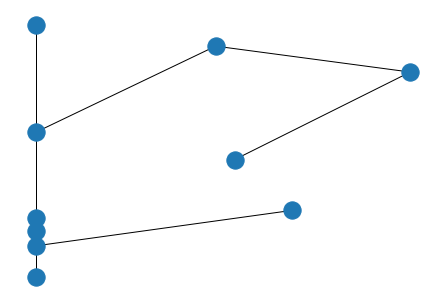

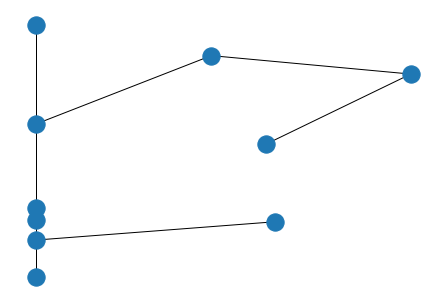

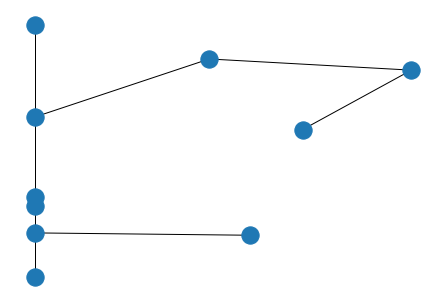

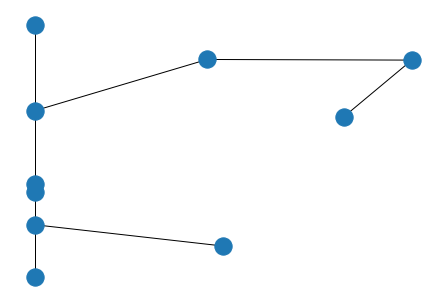

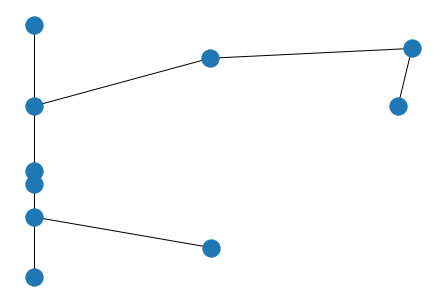

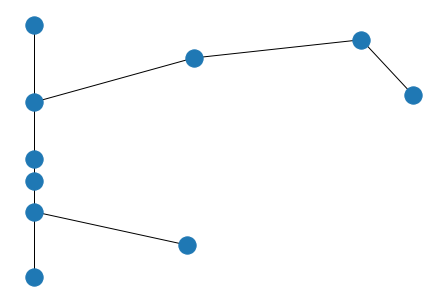

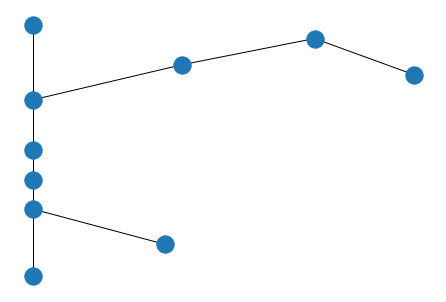

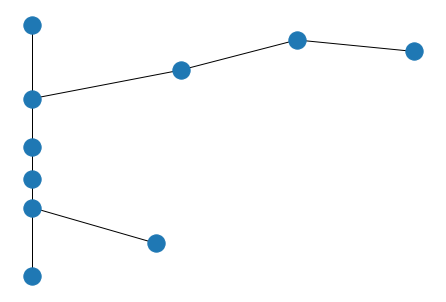

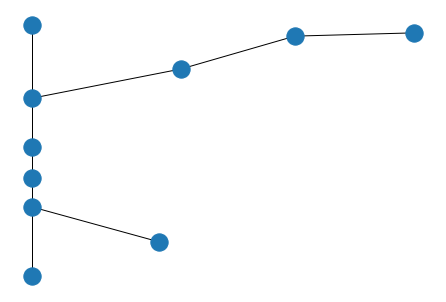

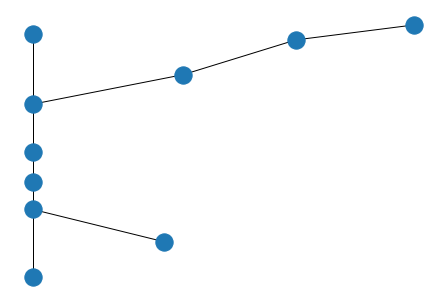

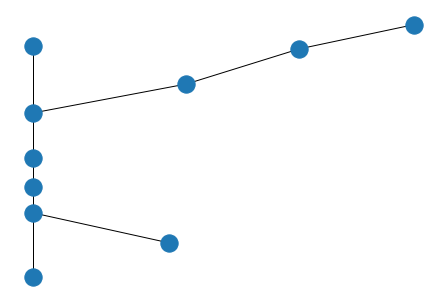

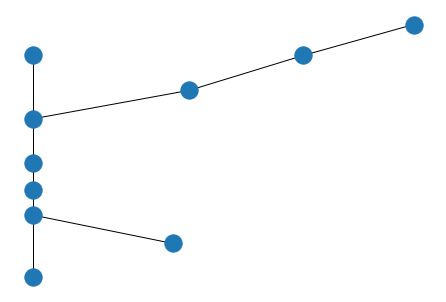

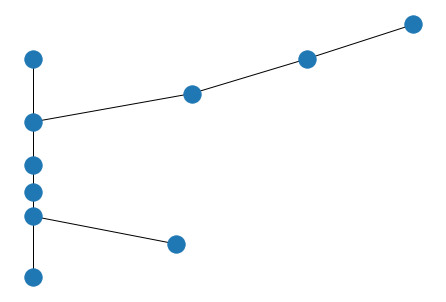

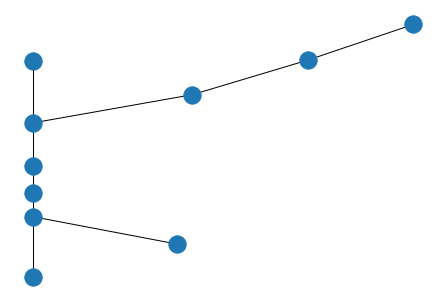

In [11]:
# 2 convolutional layer
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, output, f'test_traingraph/epoch_{i}.png')

0 tensor(4.3161, grad_fn=<AddBackward0>)
1000 tensor(3.4993, grad_fn=<AddBackward0>)
2000 tensor(2.8283, grad_fn=<AddBackward0>)
3000 tensor(2.2721, grad_fn=<AddBackward0>)
4000 tensor(1.8350, grad_fn=<AddBackward0>)
5000 tensor(1.4950, grad_fn=<AddBackward0>)
6000 tensor(1.2402, grad_fn=<AddBackward0>)
7000 tensor(1.0555, grad_fn=<AddBackward0>)
8000 tensor(0.9091, grad_fn=<AddBackward0>)
9000 tensor(0.7766, grad_fn=<AddBackward0>)
10000 tensor(0.6639, grad_fn=<AddBackward0>)
11000 tensor(0.5620, grad_fn=<AddBackward0>)
12000 tensor(0.4708, grad_fn=<AddBackward0>)
13000 tensor(0.3923, grad_fn=<AddBackward0>)
14000 tensor(0.3246, grad_fn=<AddBackward0>)
15000 tensor(0.2661, grad_fn=<AddBackward0>)
16000 tensor(0.2169, grad_fn=<AddBackward0>)
17000 tensor(0.1781, grad_fn=<AddBackward0>)
18000 tensor(0.1502, grad_fn=<AddBackward0>)
19000 tensor(0.1321, grad_fn=<AddBackward0>)
20000 tensor(0.1213, grad_fn=<AddBackward0>)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21000 tensor(0.1148, grad_fn=<AddBackward0>)
22000 tensor(0.1106, grad_fn=<AddBackward0>)
23000 tensor(0.1077, grad_fn=<AddBackward0>)
24000 tensor(0.1060, grad_fn=<AddBackward0>)
25000 tensor(0.1052, grad_fn=<AddBackward0>)
26000 tensor(0.1051, grad_fn=<AddBackward0>)
27000 tensor(0.1050, grad_fn=<AddBackward0>)
28000 tensor(0.1050, grad_fn=<AddBackward0>)
29000 tensor(0.1050, grad_fn=<AddBackward0>)
30000 tensor(0.1050, grad_fn=<AddBackward0>)
31000 tensor(0.1050, grad_fn=<AddBackward0>)
32000 tensor(0.1050, grad_fn=<AddBackward0>)
33000 tensor(0.1050, grad_fn=<AddBackward0>)
34000 tensor(0.1050, grad_fn=<AddBackward0>)
35000 tensor(0.1050, grad_fn=<AddBackward0>)
36000 tensor(0.1050, grad_fn=<AddBackward0>)
37000 tensor(0.1050, grad_fn=<AddBackward0>)
38000 tensor(0.1050, grad_fn=<AddBackward0>)
39000 tensor(0.1050, grad_fn=<AddBackward0>)
40000 tensor(0.1050, grad_fn=<AddBackward0>)
41000 tensor(0.1050, grad_fn=<AddBackward0>)
42000 tensor(0.1050, grad_fn=<AddBackward0>)
43000 tens

KeyboardInterrupt: 

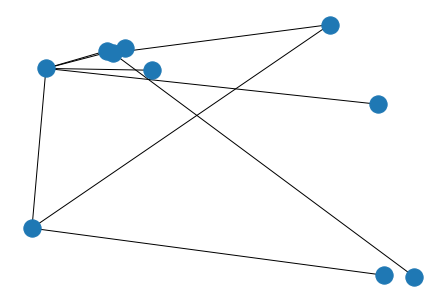

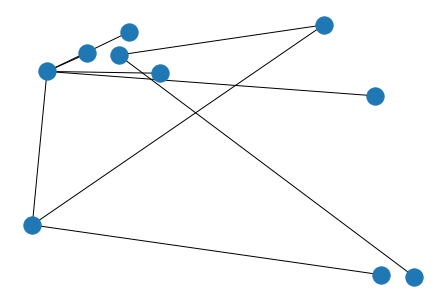

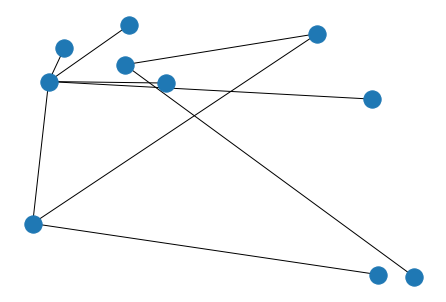

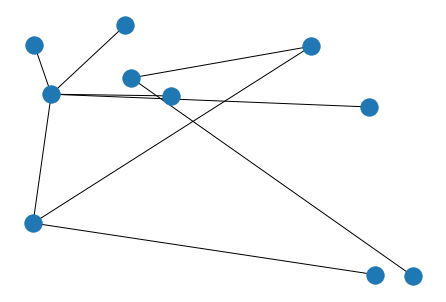

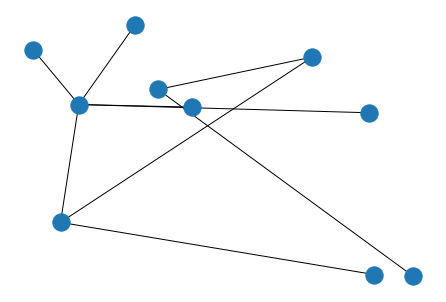

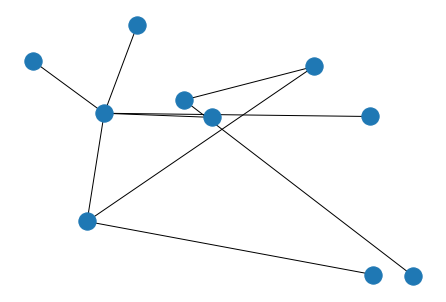

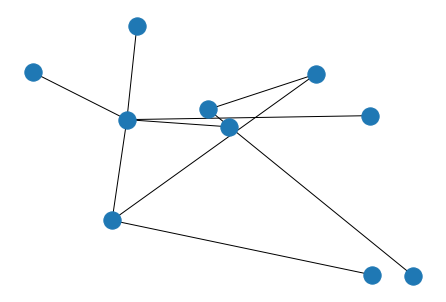

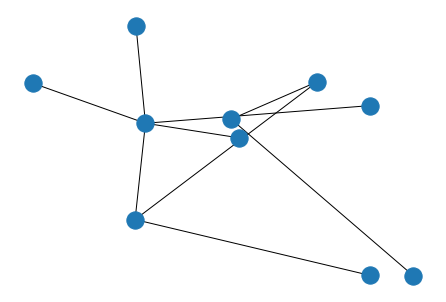

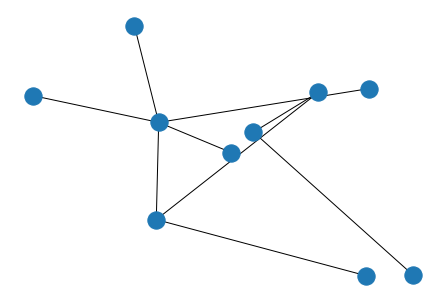

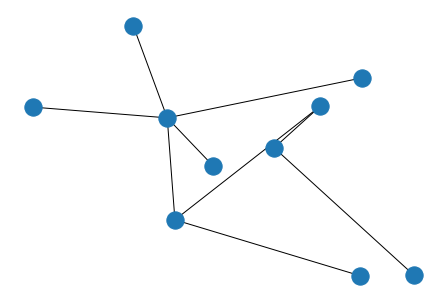

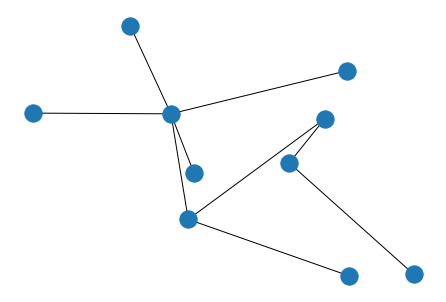

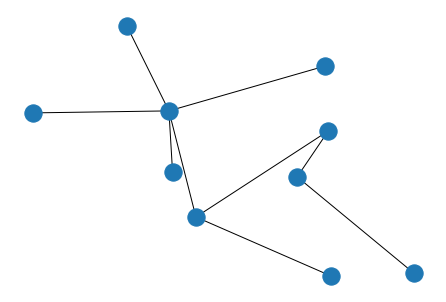

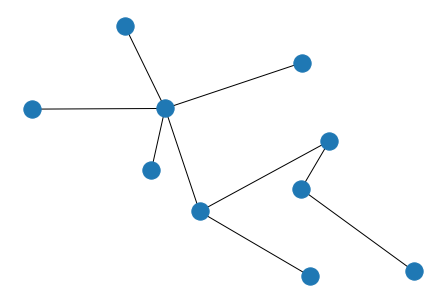

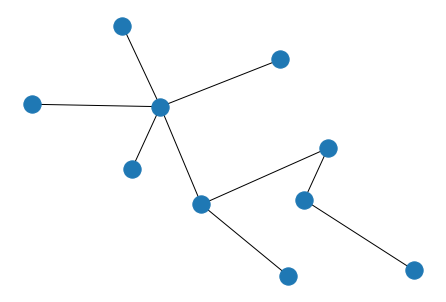

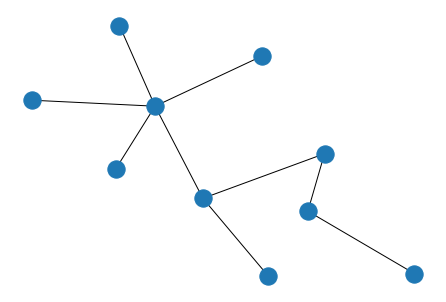

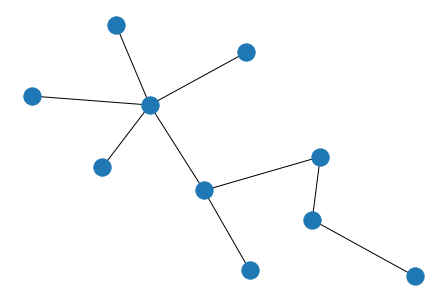

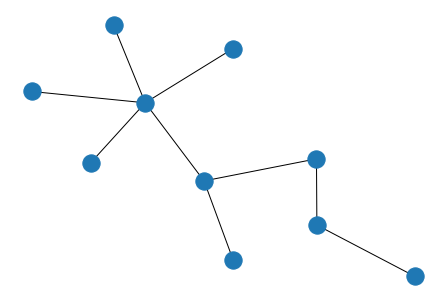

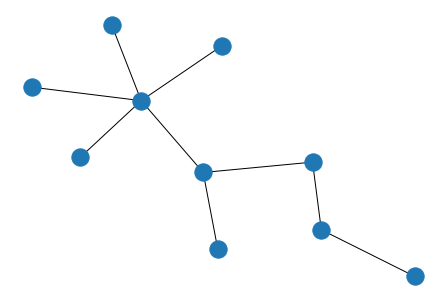

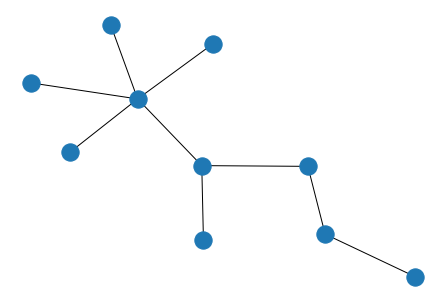

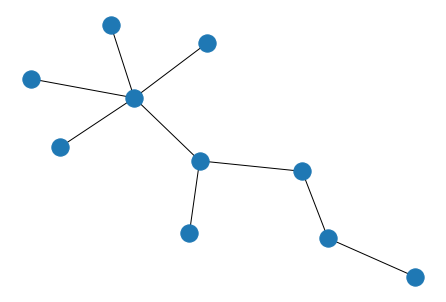

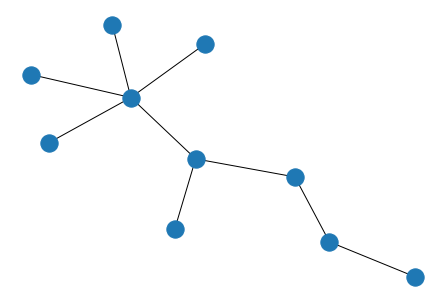

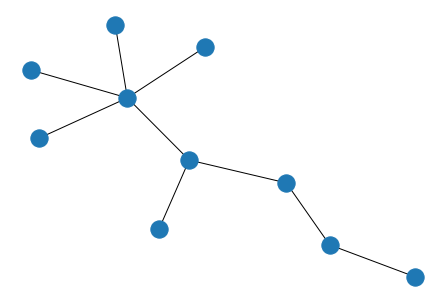

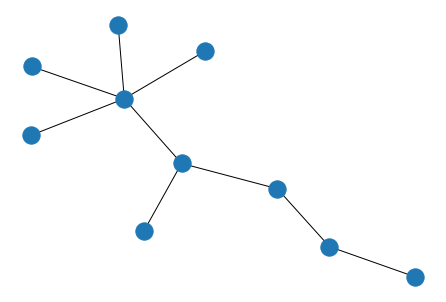

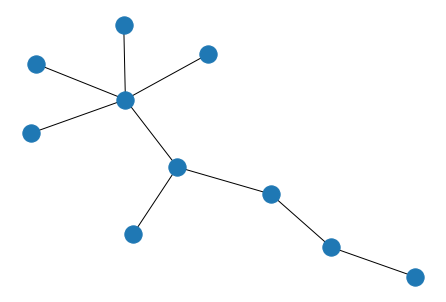

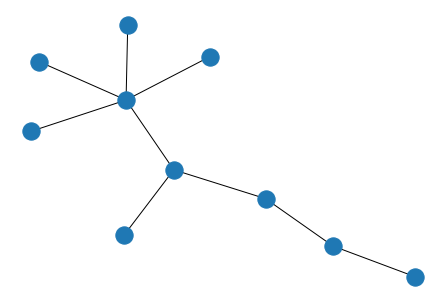

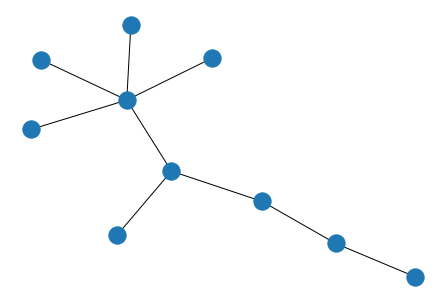

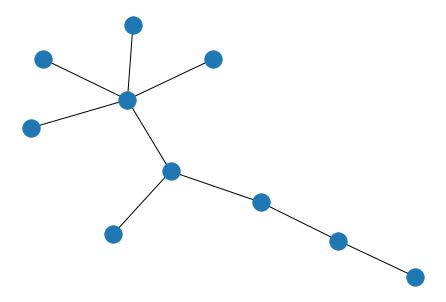

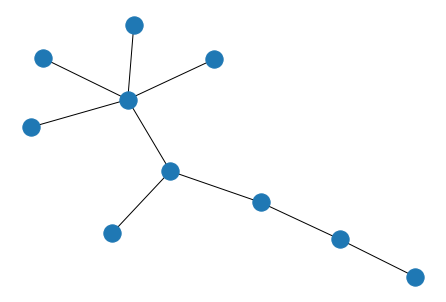

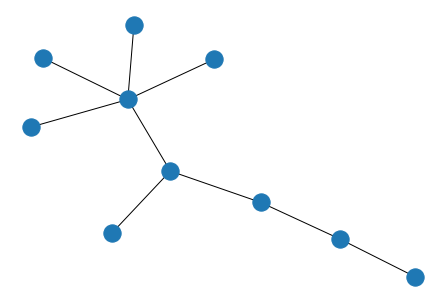

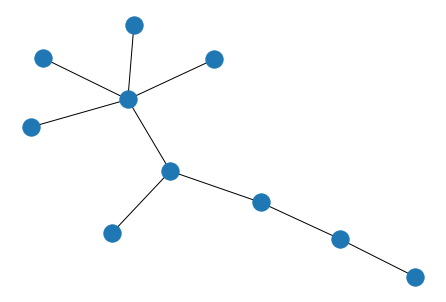

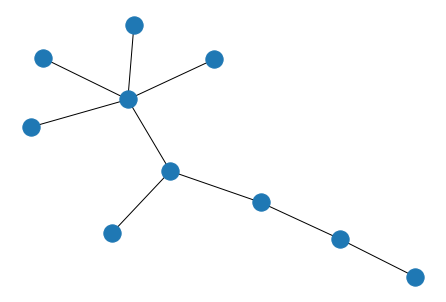

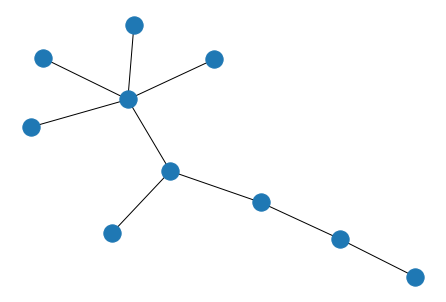

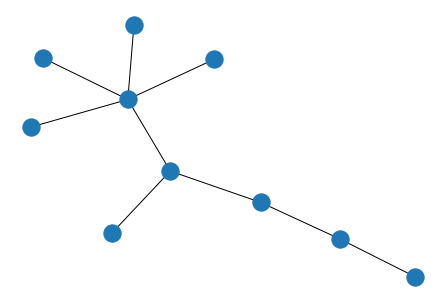

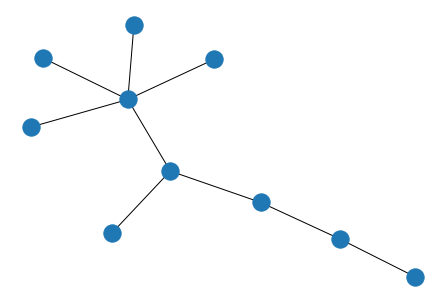

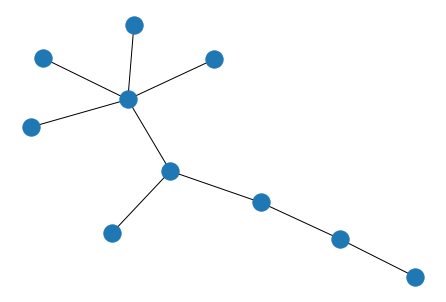

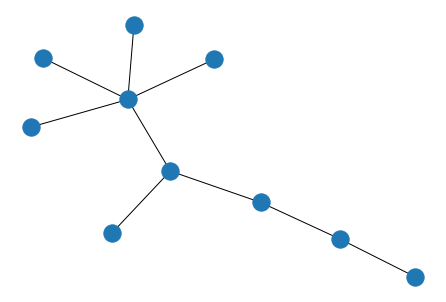

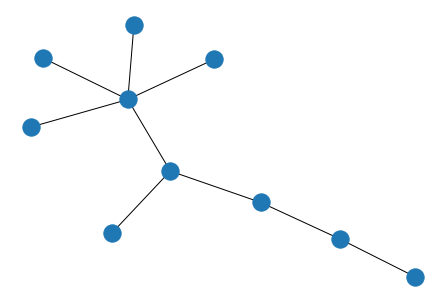

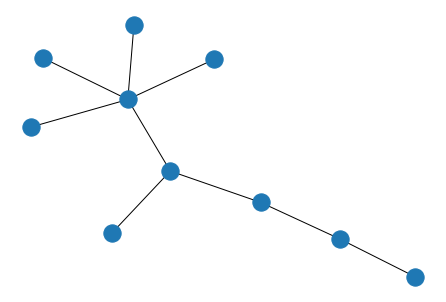

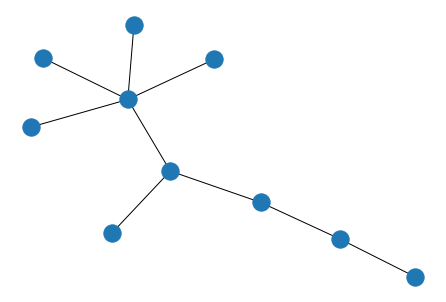

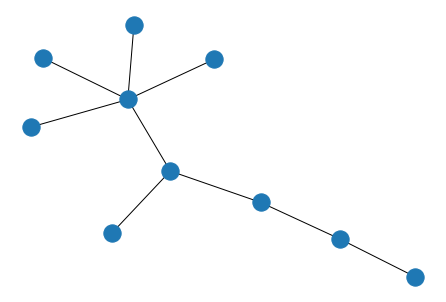

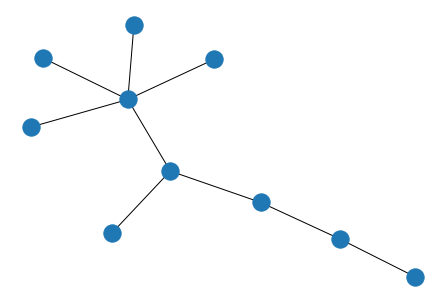

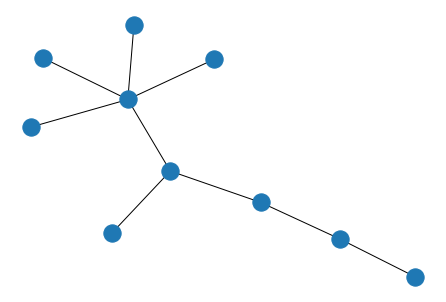

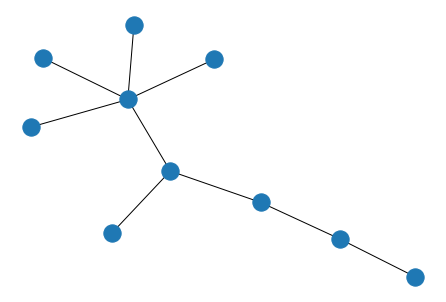

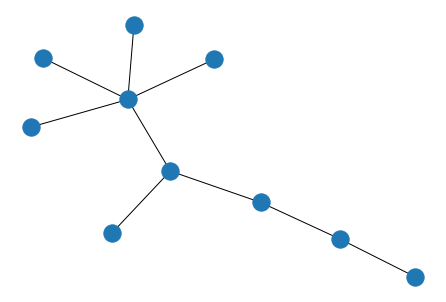

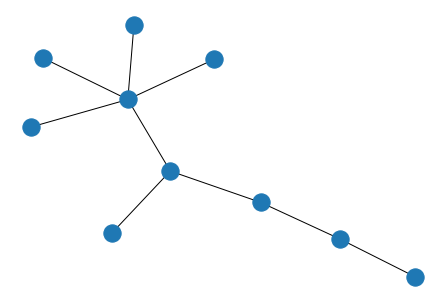

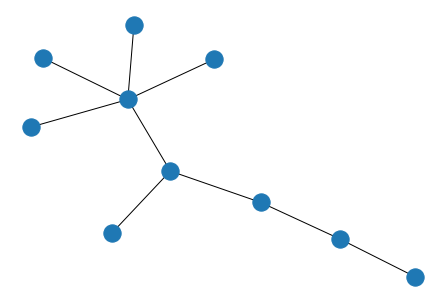

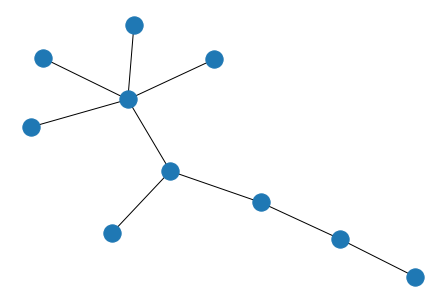

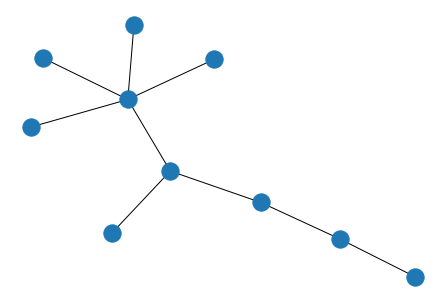

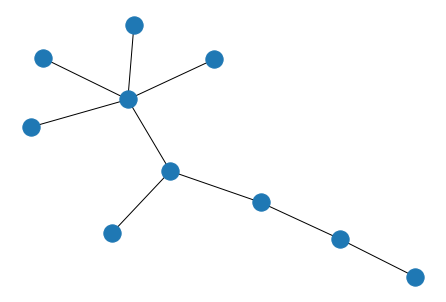

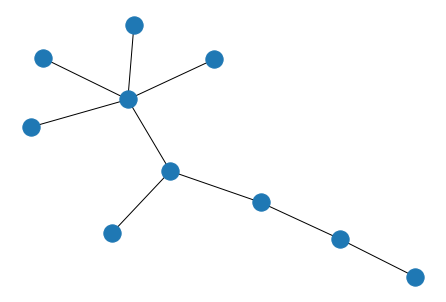

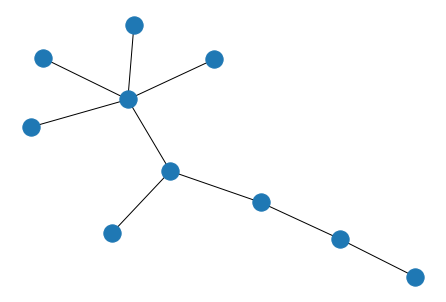

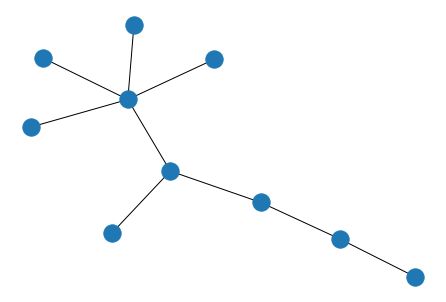

Error in callback <function flush_figures at 0x1c3383cf80> (for post_execute):


KeyboardInterrupt: 

In [12]:
# optimize data
data.x = generate_randPos(10)
optimizer = torch.optim.Adam([data.x.requires_grad_()], lr=0.00005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    optimizer.zero_grad()
    loss = criterion(data.x,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, data.x, f'test_traingraph/epoch_{i}.png')

0 tensor(794092.2500, grad_fn=<AddBackward0>)
1000 tensor(3.5692, grad_fn=<AddBackward0>)
2000 tensor(2.3514, grad_fn=<AddBackward0>)
3000 tensor(2.0832, grad_fn=<AddBackward0>)
4000 tensor(2.0336, grad_fn=<AddBackward0>)
5000 tensor(1.9494, grad_fn=<AddBackward0>)
6000 tensor(1.9025, grad_fn=<AddBackward0>)
7000 tensor(1.8721, grad_fn=<AddBackward0>)
8000 tensor(1.8537, grad_fn=<AddBackward0>)
9000 tensor(1.8470, grad_fn=<AddBackward0>)
10000 tensor(1.8252, grad_fn=<AddBackward0>)
11000 tensor(1.8238, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

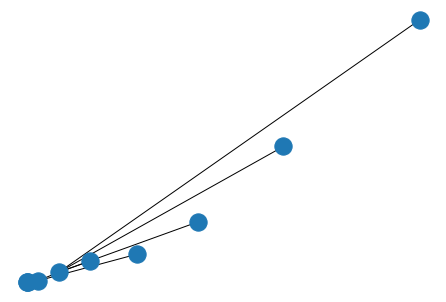

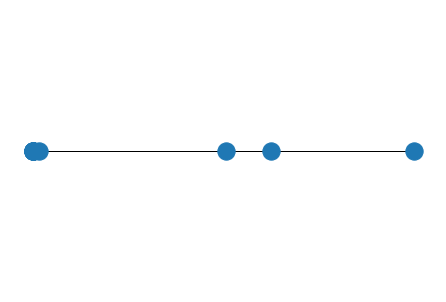

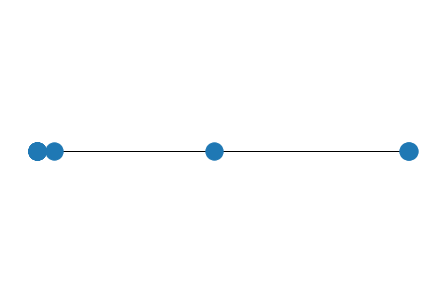

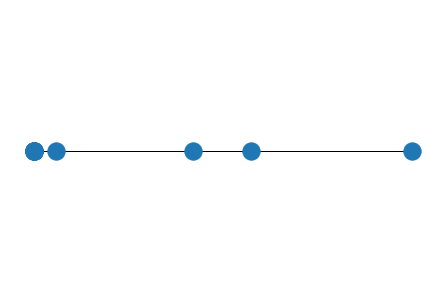

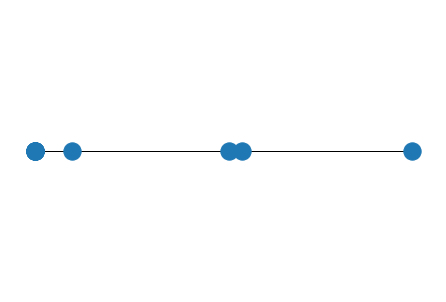

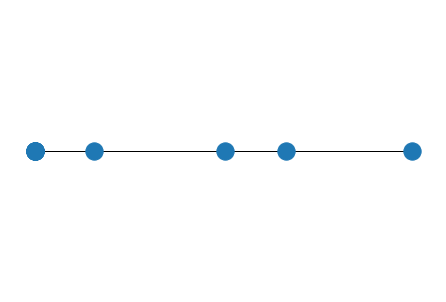

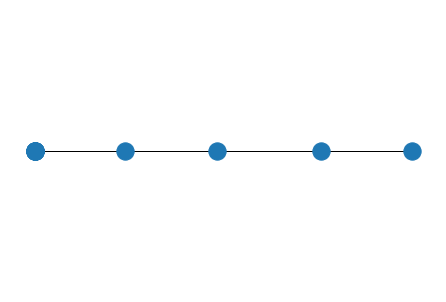

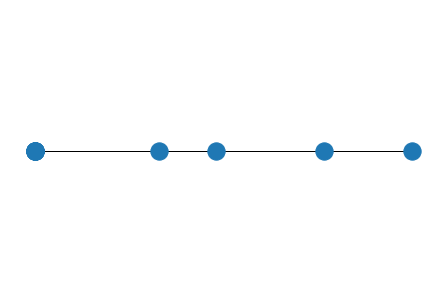

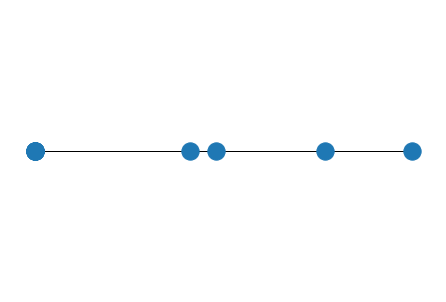

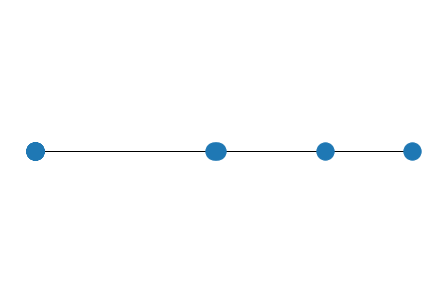

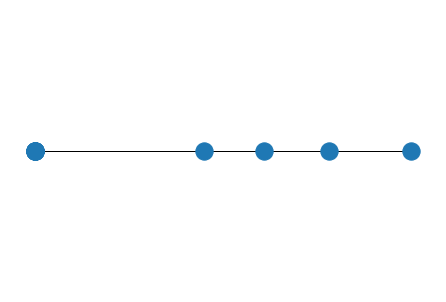

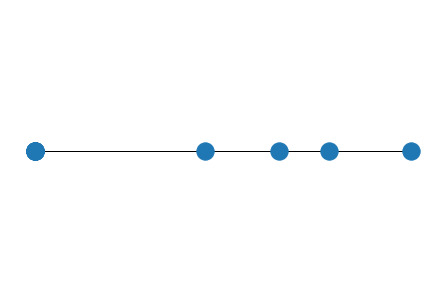

In [17]:
#4 convolutional layer
data.x = generate_randPos(10)
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, output, f'test_traingraph1/epoch_{i}.png')

0 tensor(1.4778, grad_fn=<AddBackward0>)
1000 tensor(1.1975, grad_fn=<AddBackward0>)
2000 tensor(1.0936, grad_fn=<AddBackward0>)
3000 tensor(1.0446, grad_fn=<AddBackward0>)
4000 tensor(1.0095, grad_fn=<AddBackward0>)
5000 tensor(0.9848, grad_fn=<AddBackward0>)
6000 tensor(0.9675, grad_fn=<AddBackward0>)
7000 tensor(0.9548, grad_fn=<AddBackward0>)
8000 tensor(0.9422, grad_fn=<AddBackward0>)
9000 tensor(0.9254, grad_fn=<AddBackward0>)
10000 tensor(0.9188, grad_fn=<AddBackward0>)
11000 tensor(0.8741, grad_fn=<AddBackward0>)
12000 tensor(0.8511, grad_fn=<AddBackward0>)
13000 tensor(0.8374, grad_fn=<AddBackward0>)
14000 tensor(0.8265, grad_fn=<AddBackward0>)
15000 tensor(0.8161, grad_fn=<AddBackward0>)
16000 tensor(0.8057, grad_fn=<AddBackward0>)
17000 tensor(0.7993, grad_fn=<AddBackward0>)
18000 tensor(0.7940, grad_fn=<AddBackward0>)
19000 tensor(0.7893, grad_fn=<AddBackward0>)
20000 tensor(0.7851, grad_fn=<AddBackward0>)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21000 tensor(0.7743, grad_fn=<AddBackward0>)
22000 tensor(0.7327, grad_fn=<AddBackward0>)
23000 tensor(0.6963, grad_fn=<AddBackward0>)
24000 tensor(0.6701, grad_fn=<AddBackward0>)
25000 tensor(0.6403, grad_fn=<AddBackward0>)
26000 tensor(0.6133, grad_fn=<AddBackward0>)
27000 tensor(0.5927, grad_fn=<AddBackward0>)
28000 tensor(0.5698, grad_fn=<AddBackward0>)
29000 tensor(0.5399, grad_fn=<AddBackward0>)
30000 tensor(0.5222, grad_fn=<AddBackward0>)
31000 tensor(0.4547, grad_fn=<AddBackward0>)
32000 tensor(0.4263, grad_fn=<AddBackward0>)
33000 tensor(0.4153, grad_fn=<AddBackward0>)
34000 tensor(0.4111, grad_fn=<AddBackward0>)
35000 tensor(0.3958, grad_fn=<AddBackward0>)
36000 tensor(0.3231, grad_fn=<AddBackward0>)
37000 tensor(0.2854, grad_fn=<AddBackward0>)
38000 tensor(0.2745, grad_fn=<AddBackward0>)
39000 tensor(0.2692, grad_fn=<AddBackward0>)
40000 tensor(0.2663, grad_fn=<AddBackward0>)
41000 tensor(0.2645, grad_fn=<AddBackward0>)
42000 tensor(0.2631, grad_fn=<AddBackward0>)
43000 tens

KeyboardInterrupt: 

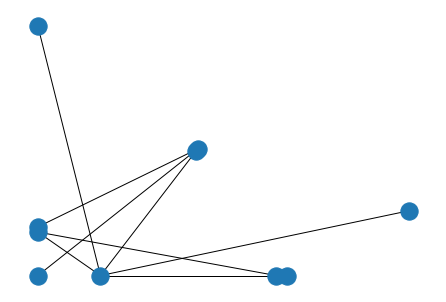

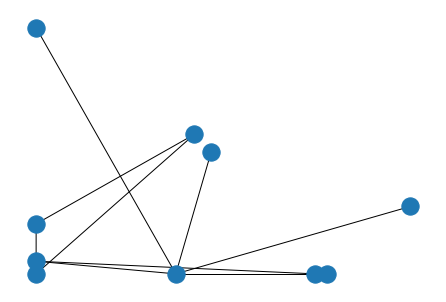

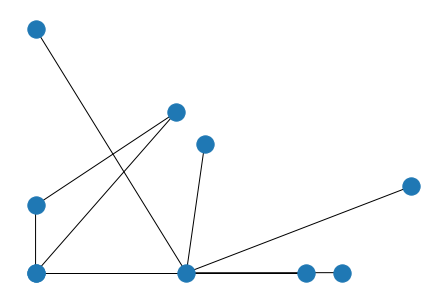

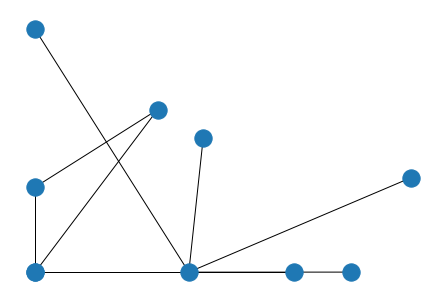

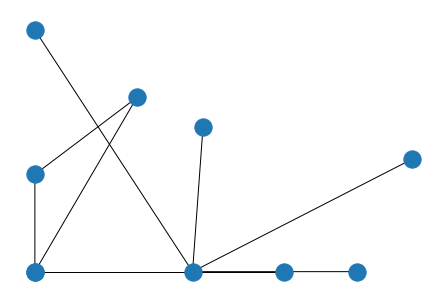

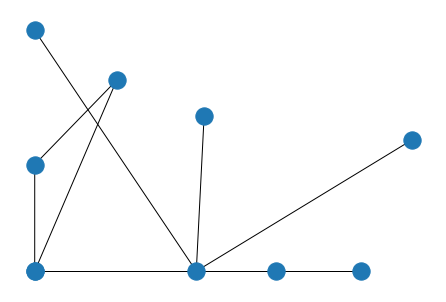

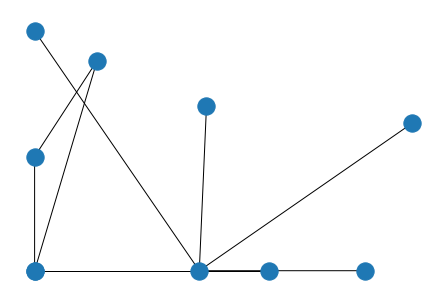

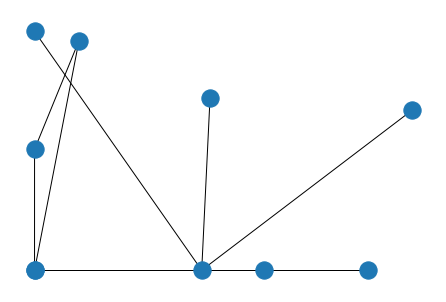

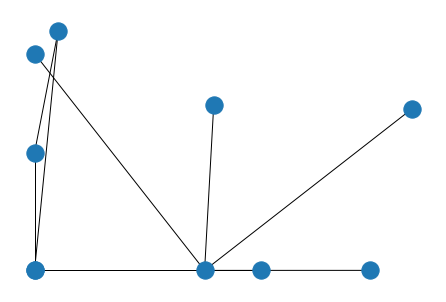

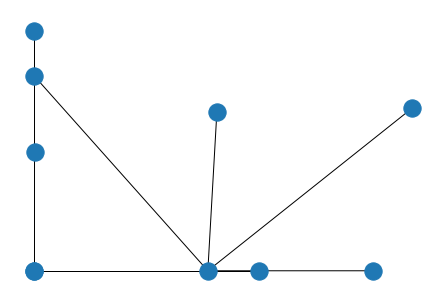

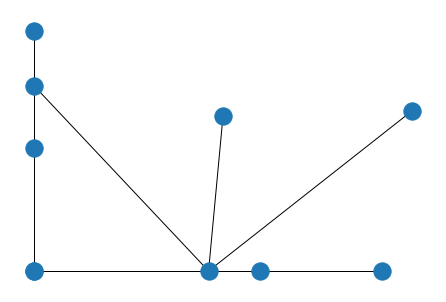

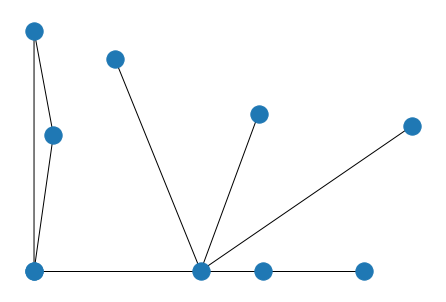

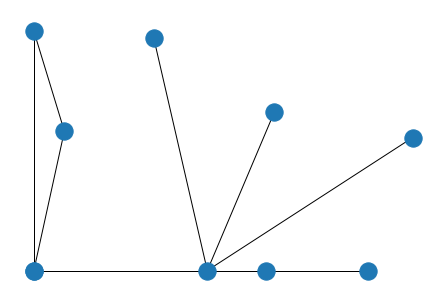

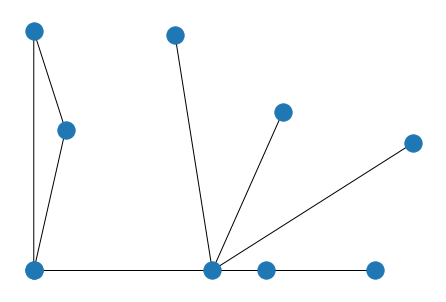

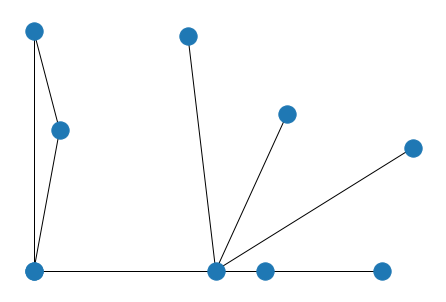

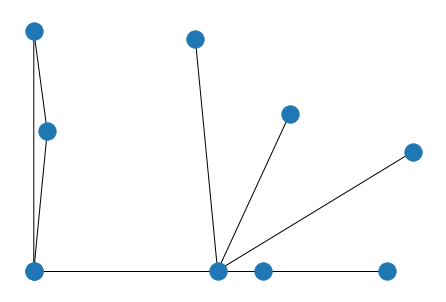

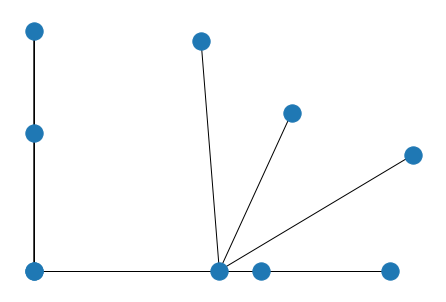

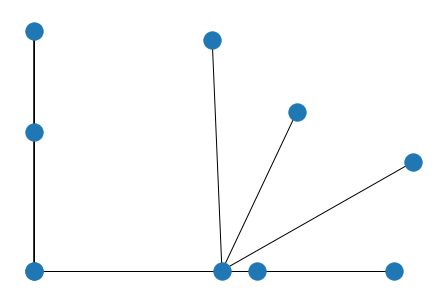

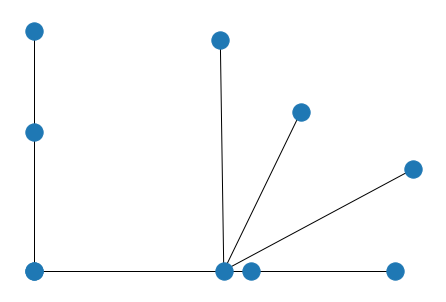

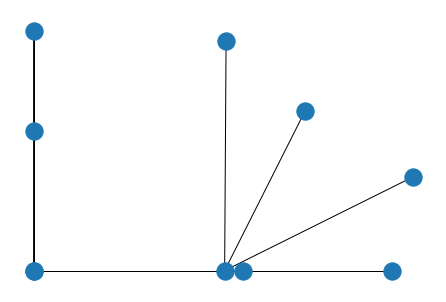

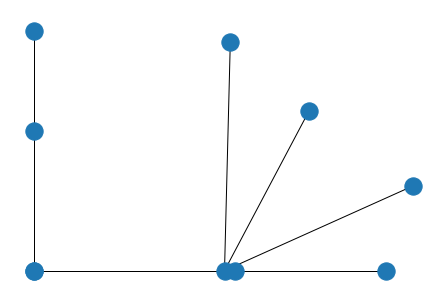

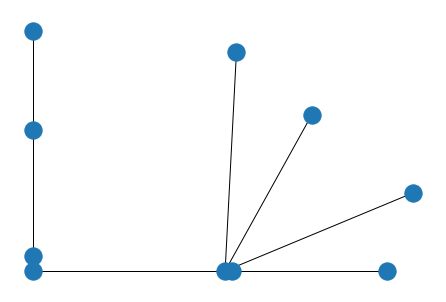

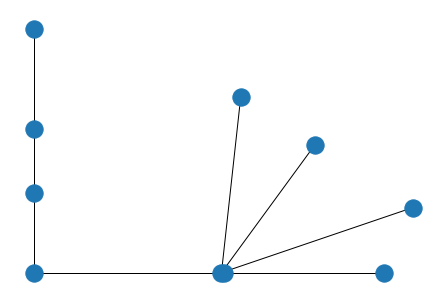

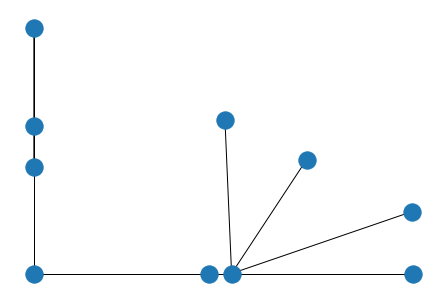

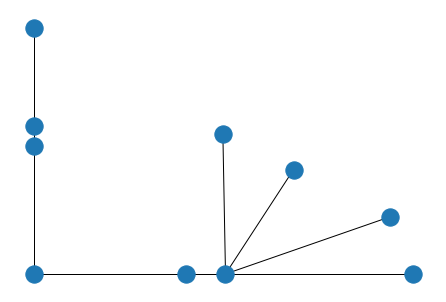

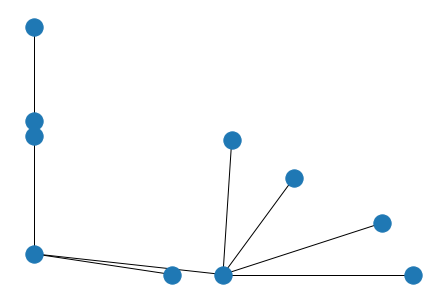

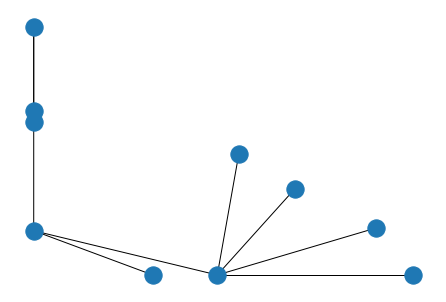

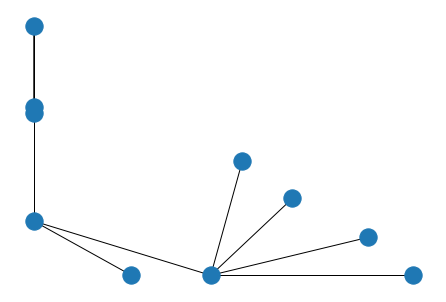

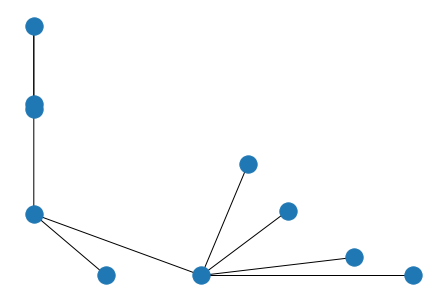

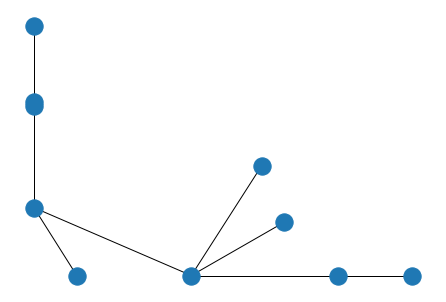

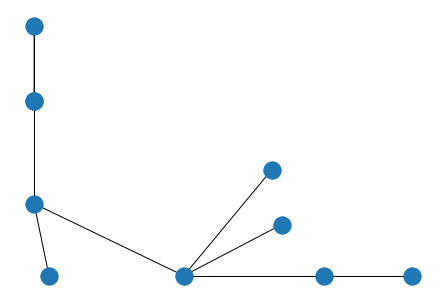

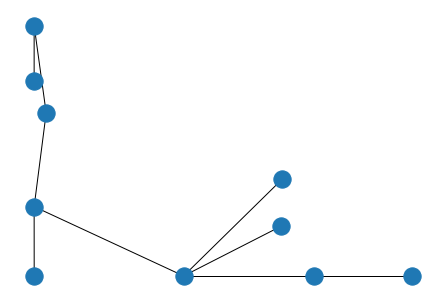

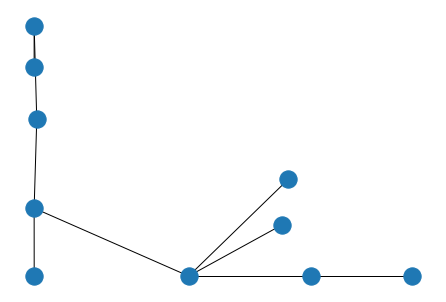

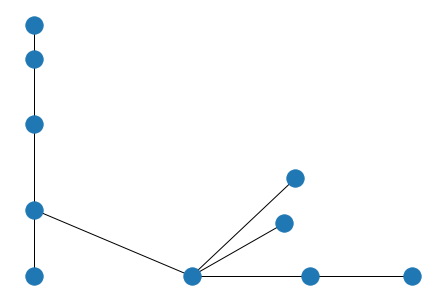

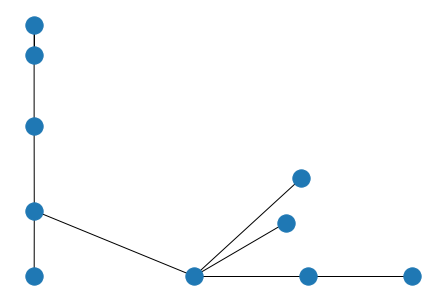

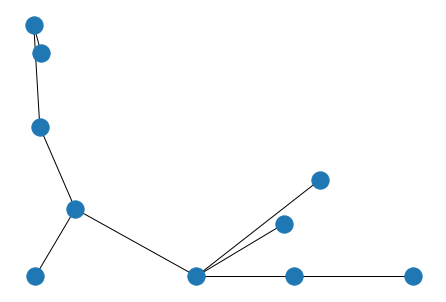

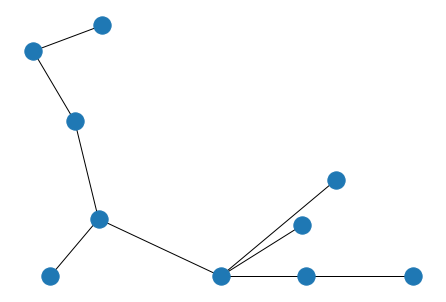

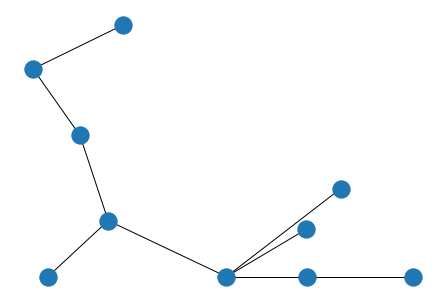

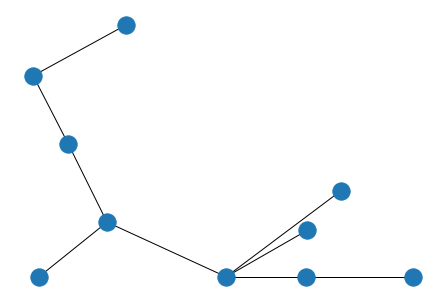

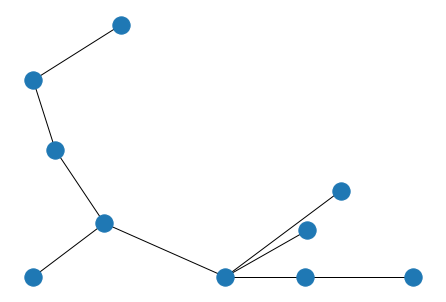

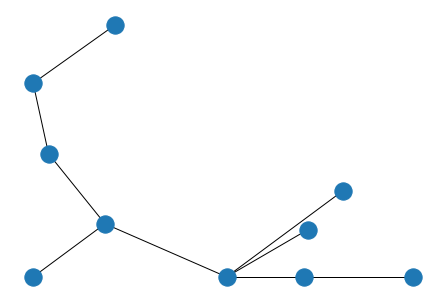

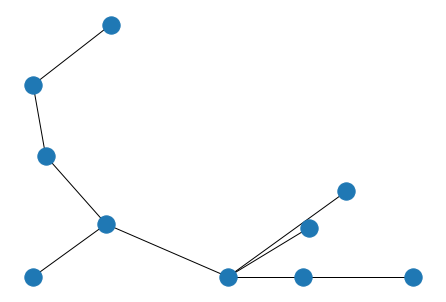

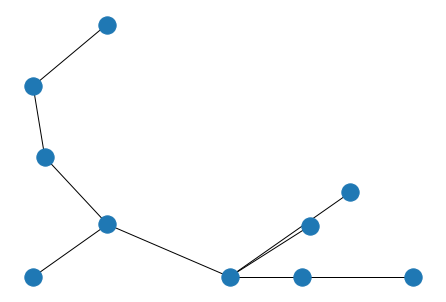

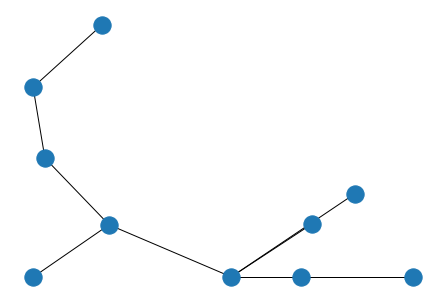

In [19]:
# 1 convolutional layer
data.x = generate_randPos(10)
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, output, f'test_traingraph1/epoch_{i}.png')

0 tensor(6837925., grad_fn=<AddBackward0>)
1000 tensor(777.8760, grad_fn=<AddBackward0>)
2000 tensor(2.9189, grad_fn=<AddBackward0>)
3000 tensor(2.8921, grad_fn=<AddBackward0>)
4000 tensor(2.8905, grad_fn=<AddBackward0>)
5000 tensor(2.8896, grad_fn=<AddBackward0>)
6000 tensor(2.8884, grad_fn=<AddBackward0>)
7000 tensor(2.8866, grad_fn=<AddBackward0>)
8000 tensor(2.8839, grad_fn=<AddBackward0>)
9000 tensor(2.8802, grad_fn=<AddBackward0>)
10000 tensor(2.8753, grad_fn=<AddBackward0>)
11000 tensor(2.8688, grad_fn=<AddBackward0>)
12000 tensor(2.8604, grad_fn=<AddBackward0>)
13000 tensor(2.8497, grad_fn=<AddBackward0>)
14000 tensor(2.8360, grad_fn=<AddBackward0>)
15000 tensor(2.4021, grad_fn=<AddBackward0>)
16000 tensor(2.3799, grad_fn=<AddBackward0>)
17000 tensor(2.3532, grad_fn=<AddBackward0>)
18000 tensor(2.3220, grad_fn=<AddBackward0>)
19000 tensor(2.7738, grad_fn=<AddBackward0>)
20000 tensor(2.7290, grad_fn=<AddBackward0>)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21000 tensor(2.6810, grad_fn=<AddBackward0>)
22000 tensor(2.6280, grad_fn=<AddBackward0>)
23000 tensor(2.5771, grad_fn=<AddBackward0>)
24000 tensor(2.5349, grad_fn=<AddBackward0>)
25000 tensor(2.5070, grad_fn=<AddBackward0>)
26000 tensor(2.4967, grad_fn=<AddBackward0>)
27000 tensor(2.4962, grad_fn=<AddBackward0>)
28000 tensor(2.4962, grad_fn=<AddBackward0>)
29000 tensor(2.4962, grad_fn=<AddBackward0>)
30000 tensor(2.4962, grad_fn=<AddBackward0>)
31000 tensor(2.4962, grad_fn=<AddBackward0>)
32000 tensor(2.4962, grad_fn=<AddBackward0>)
33000 tensor(2.4962, grad_fn=<AddBackward0>)
34000 tensor(2.4962, grad_fn=<AddBackward0>)
35000 tensor(2.4962, grad_fn=<AddBackward0>)
36000 tensor(2.4962, grad_fn=<AddBackward0>)
37000 tensor(2.4962, grad_fn=<AddBackward0>)
38000 tensor(2.4962, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

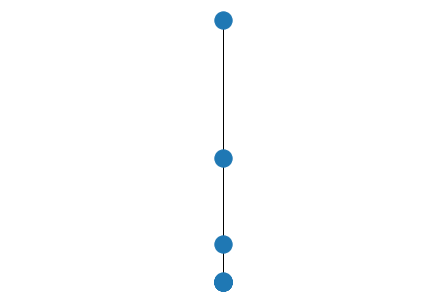

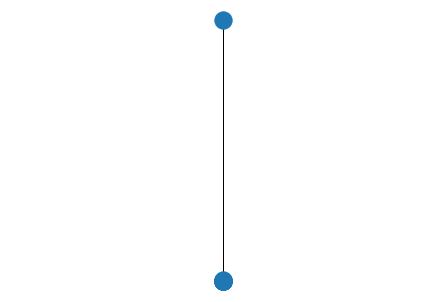

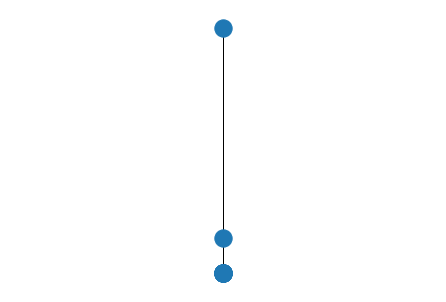

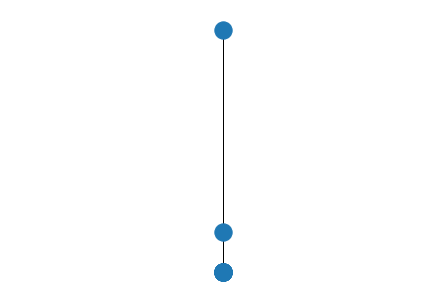

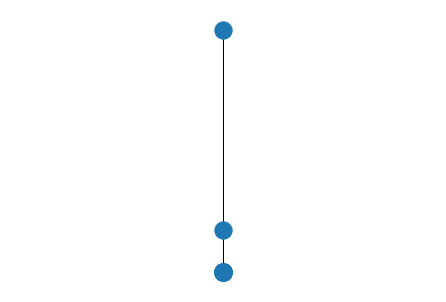

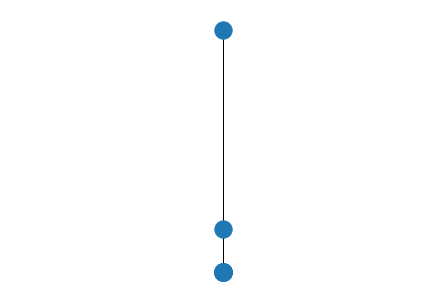

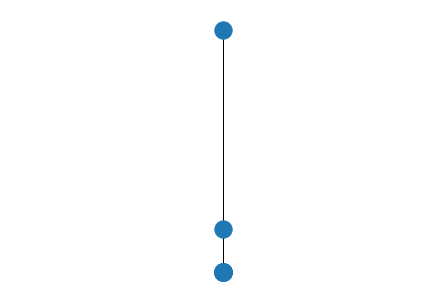

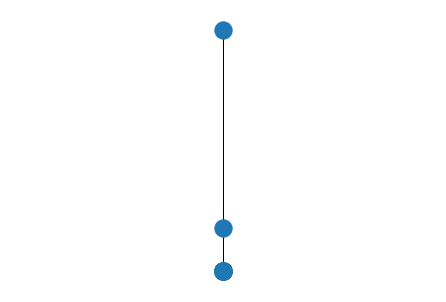

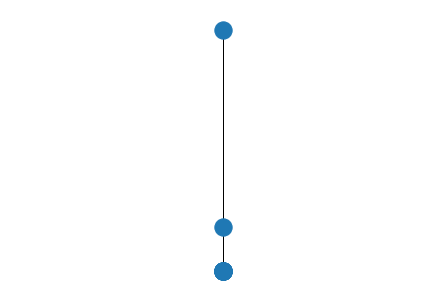

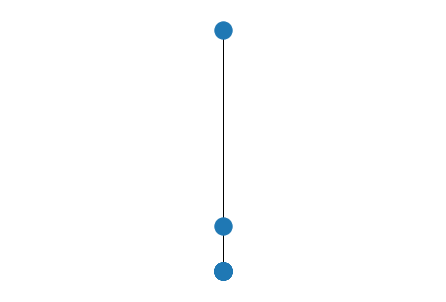

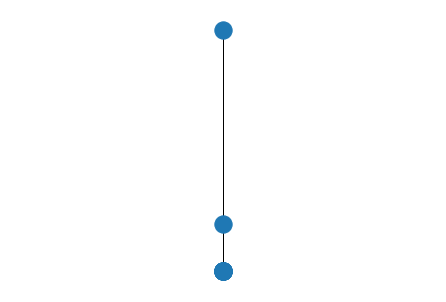

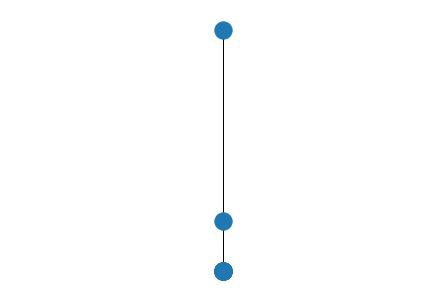

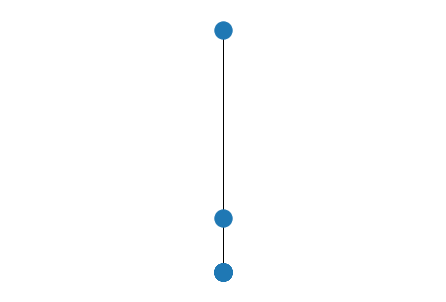

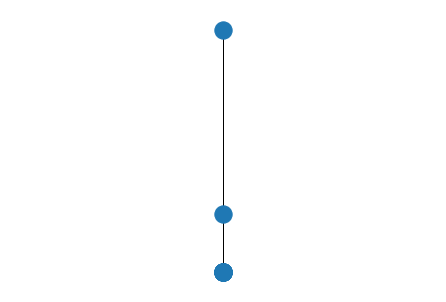

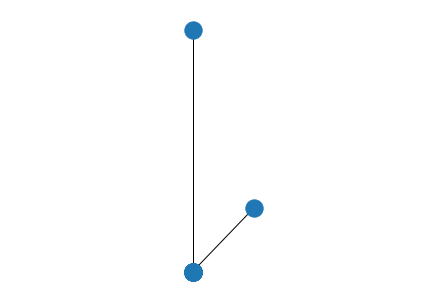

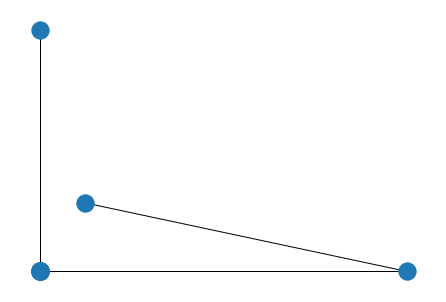

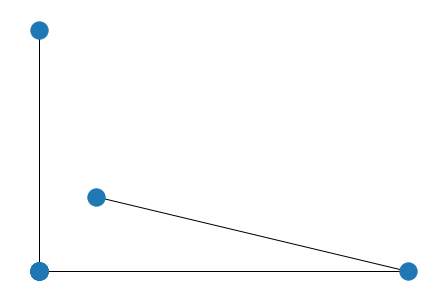

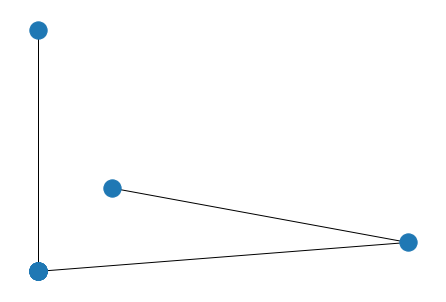

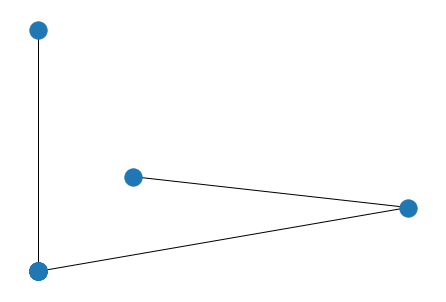

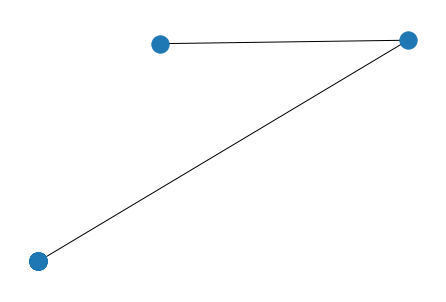

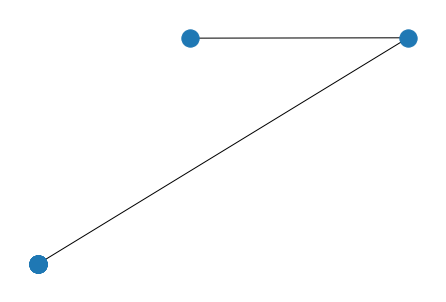

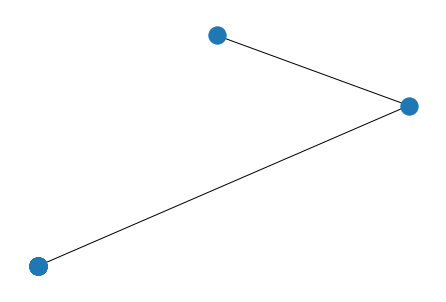

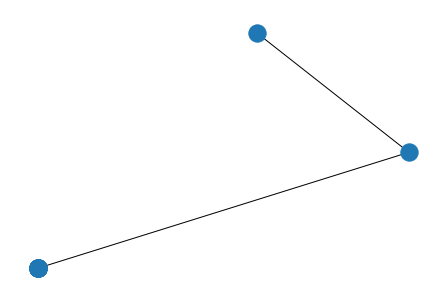

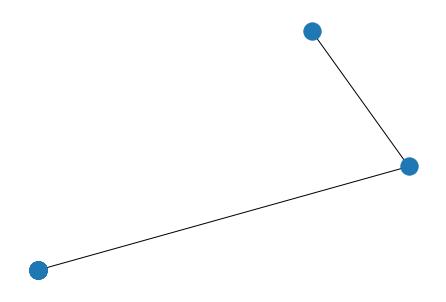

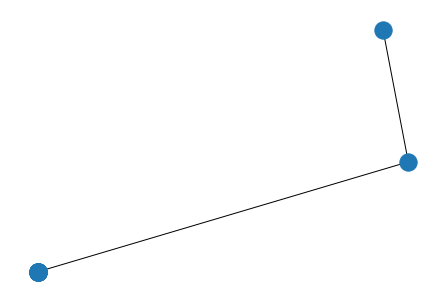

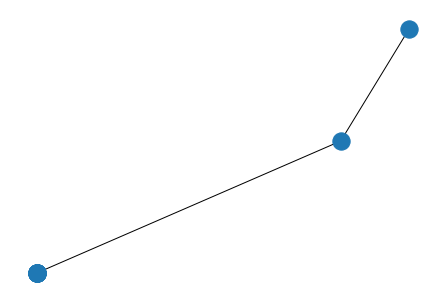

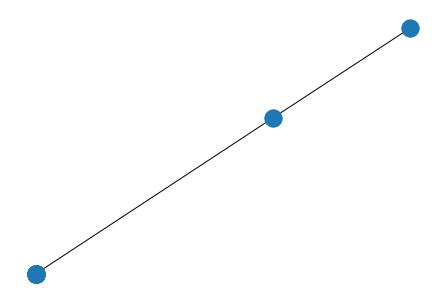

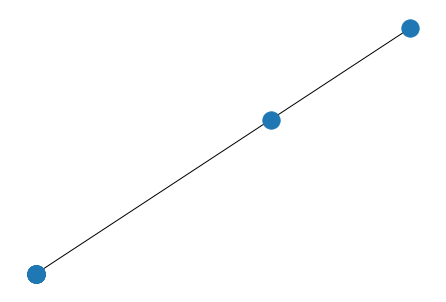

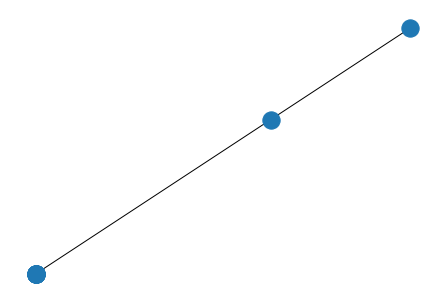

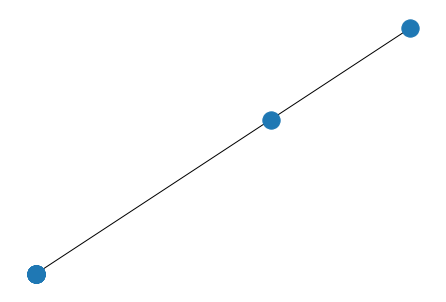

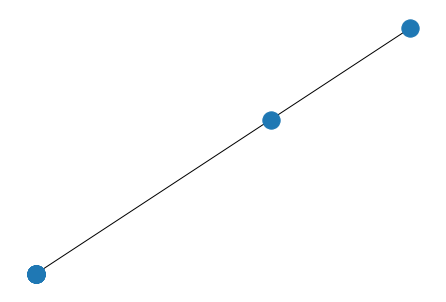

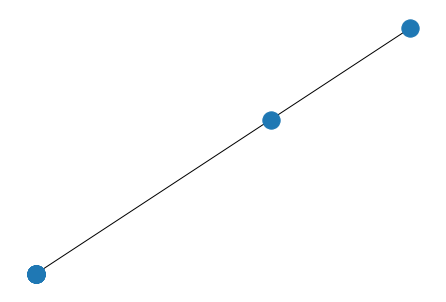

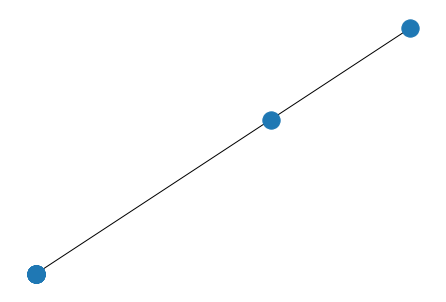

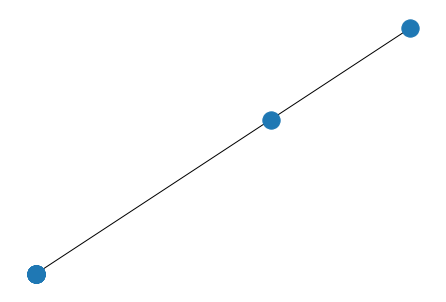

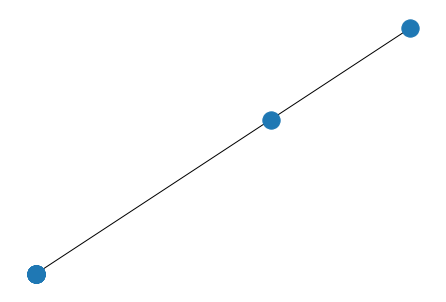

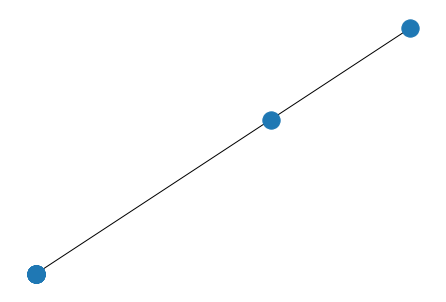

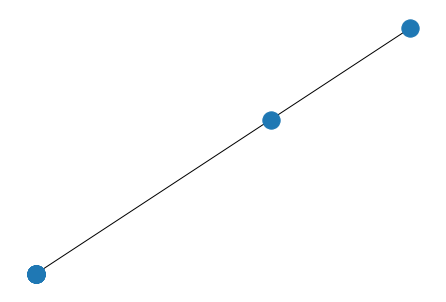

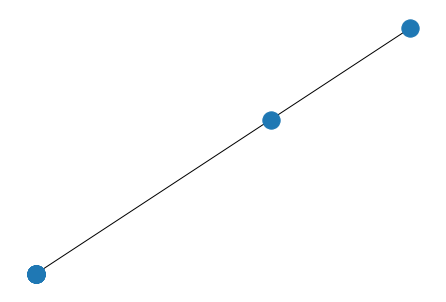

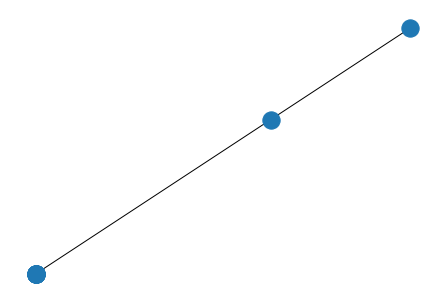

In [23]:
# 5 convolutional layer
data.x = generate_randPos(10)
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, output, f'test_traingraph5/epoch_{i}.png')

0 tensor(2.4938, grad_fn=<AddBackward0>)
1000 tensor(2.3926, grad_fn=<AddBackward0>)
2000 tensor(2.2938, grad_fn=<AddBackward0>)
3000 tensor(2.1754, grad_fn=<AddBackward0>)
4000 tensor(2.0387, grad_fn=<AddBackward0>)
5000 tensor(1.9405, grad_fn=<AddBackward0>)
6000 tensor(1.8326, grad_fn=<AddBackward0>)
7000 tensor(1.7437, grad_fn=<AddBackward0>)
8000 tensor(1.6767, grad_fn=<AddBackward0>)
9000 tensor(1.6251, grad_fn=<AddBackward0>)
10000 tensor(1.5793, grad_fn=<AddBackward0>)
11000 tensor(1.5368, grad_fn=<AddBackward0>)
12000 tensor(1.4874, grad_fn=<AddBackward0>)
13000 tensor(1.4131, grad_fn=<AddBackward0>)
14000 tensor(1.3577, grad_fn=<AddBackward0>)
15000 tensor(1.2994, grad_fn=<AddBackward0>)
16000 tensor(1.2417, grad_fn=<AddBackward0>)
17000 tensor(1.1430, grad_fn=<AddBackward0>)
18000 tensor(1.0650, grad_fn=<AddBackward0>)
19000 tensor(0.9968, grad_fn=<AddBackward0>)
20000 tensor(0.9378, grad_fn=<AddBackward0>)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21000 tensor(0.8957, grad_fn=<AddBackward0>)
22000 tensor(0.8564, grad_fn=<AddBackward0>)
23000 tensor(0.8197, grad_fn=<AddBackward0>)
24000 tensor(0.7891, grad_fn=<AddBackward0>)
25000 tensor(0.7609, grad_fn=<AddBackward0>)
26000 tensor(0.7333, grad_fn=<AddBackward0>)
27000 tensor(0.7063, grad_fn=<AddBackward0>)
28000 tensor(0.6803, grad_fn=<AddBackward0>)
29000 tensor(0.6565, grad_fn=<AddBackward0>)
30000 tensor(0.6348, grad_fn=<AddBackward0>)
31000 tensor(0.6146, grad_fn=<AddBackward0>)
32000 tensor(0.5957, grad_fn=<AddBackward0>)
33000 tensor(0.5775, grad_fn=<AddBackward0>)
34000 tensor(0.5576, grad_fn=<AddBackward0>)
35000 tensor(0.5303, grad_fn=<AddBackward0>)
36000 tensor(0.5040, grad_fn=<AddBackward0>)
37000 tensor(0.4815, grad_fn=<AddBackward0>)
38000 tensor(0.4638, grad_fn=<AddBackward0>)
39000 tensor(0.4486, grad_fn=<AddBackward0>)
40000 tensor(0.4354, grad_fn=<AddBackward0>)
41000 tensor(0.4237, grad_fn=<AddBackward0>)
42000 tensor(0.4134, grad_fn=<AddBackward0>)
43000 tens

KeyboardInterrupt: 

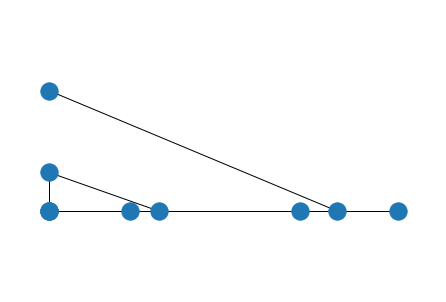

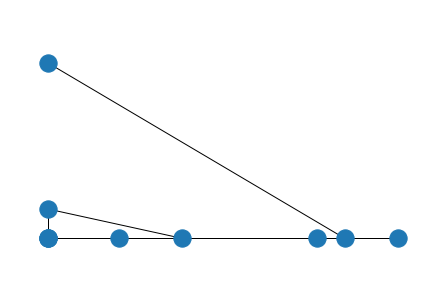

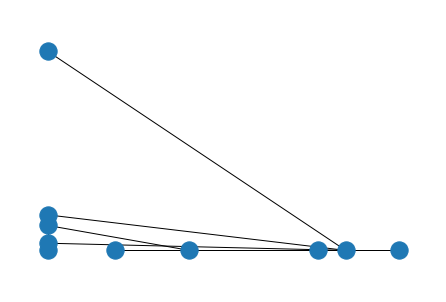

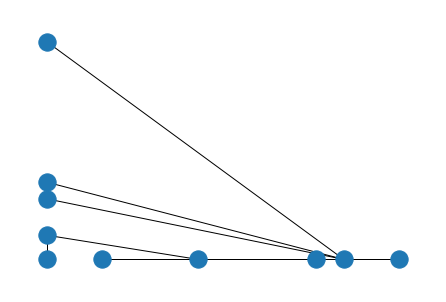

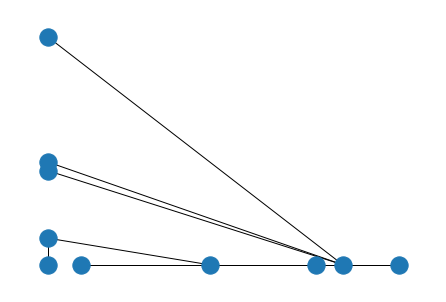

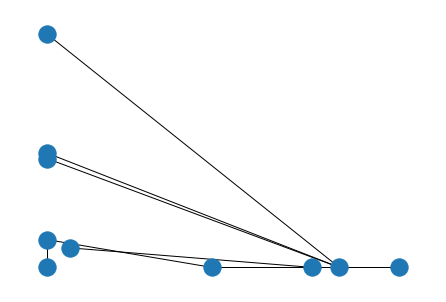

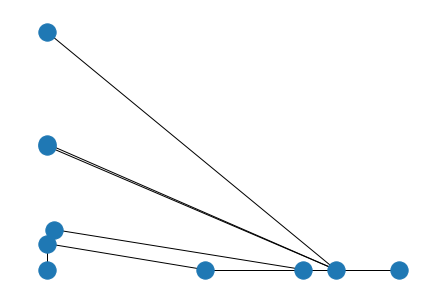

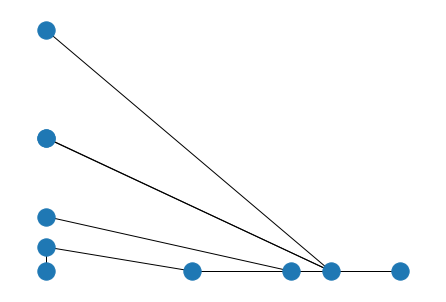

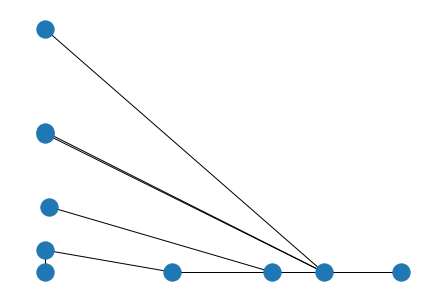

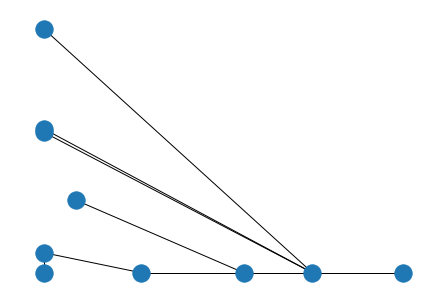

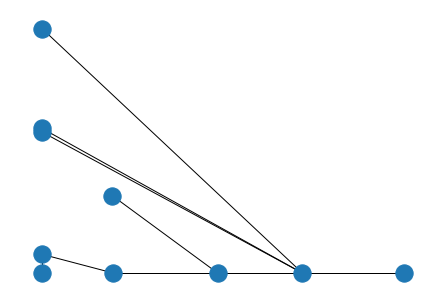

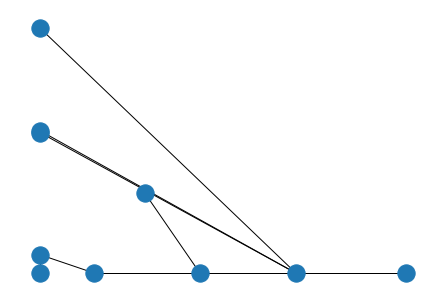

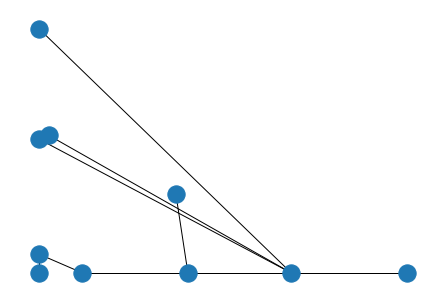

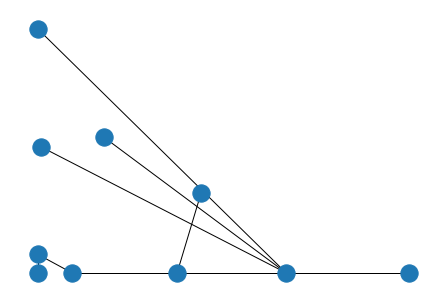

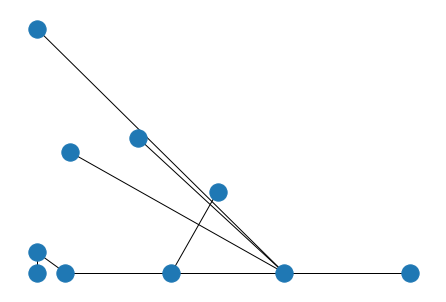

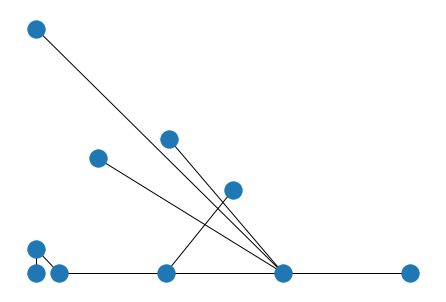

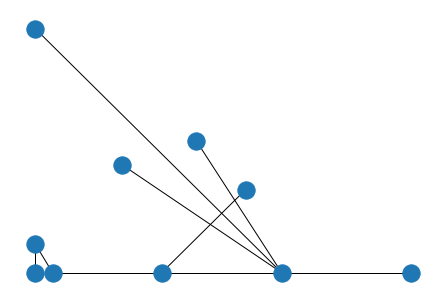

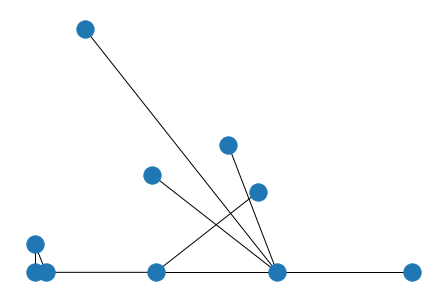

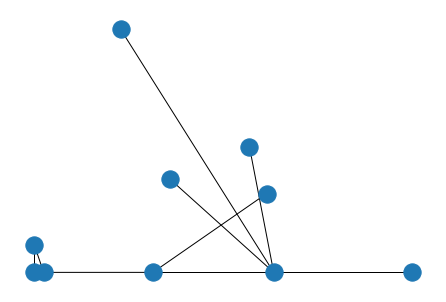

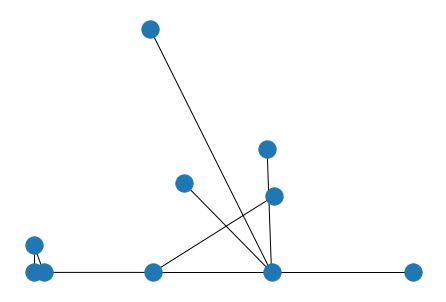

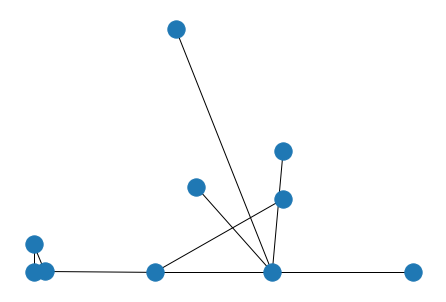

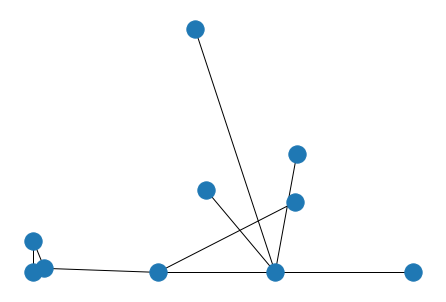

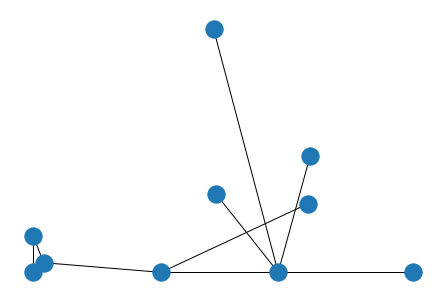

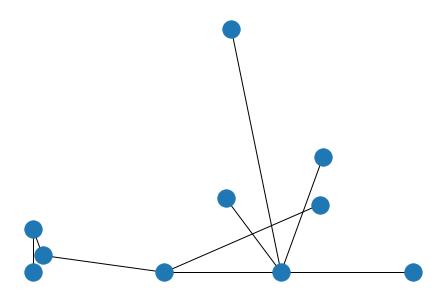

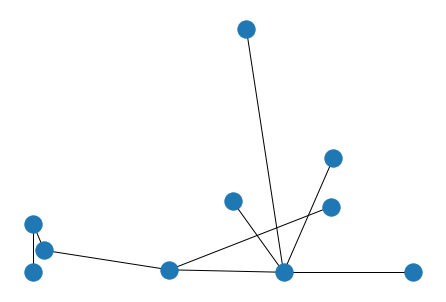

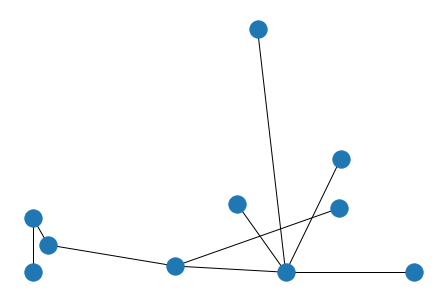

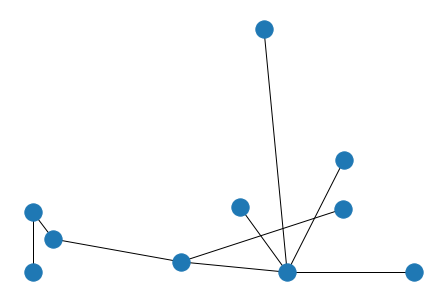

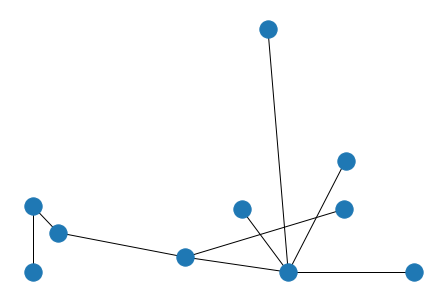

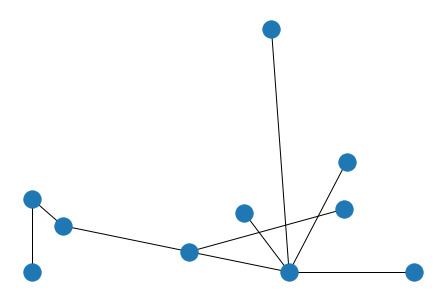

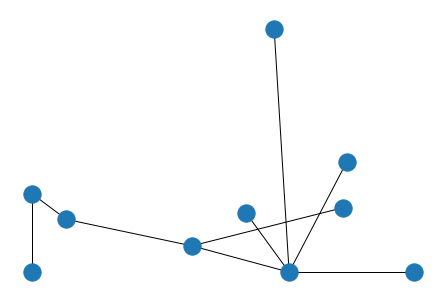

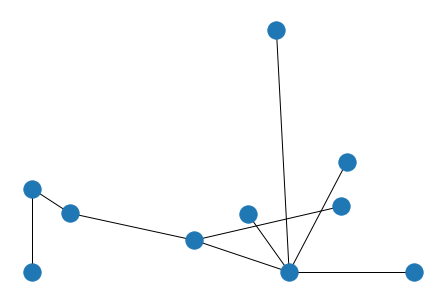

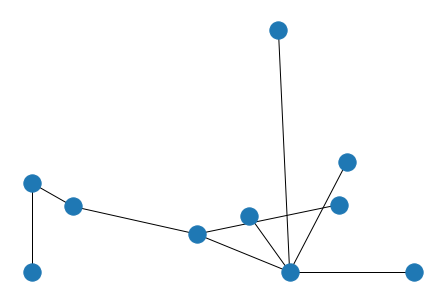

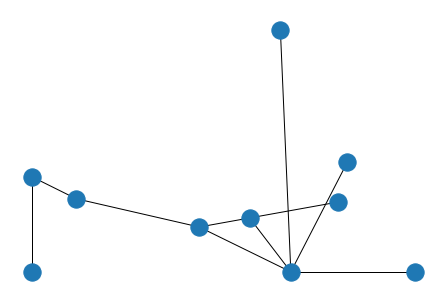

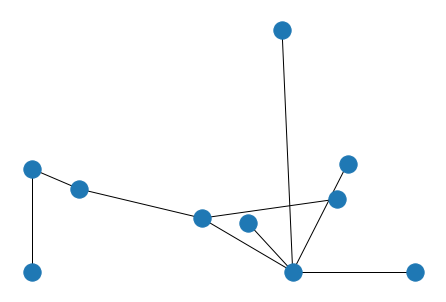

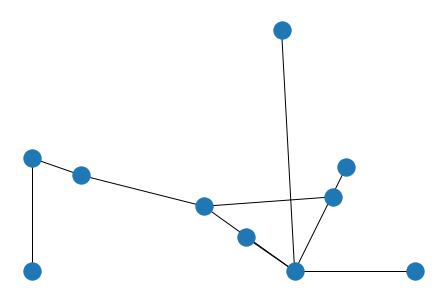

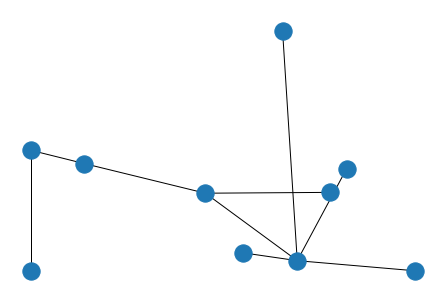

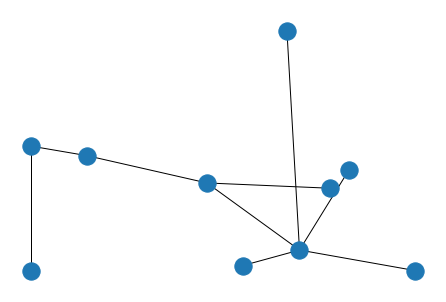

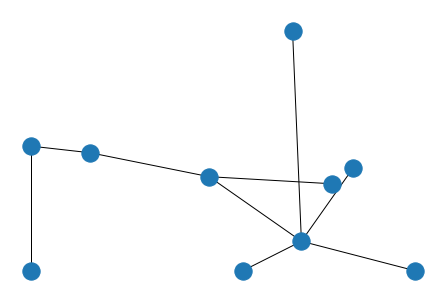

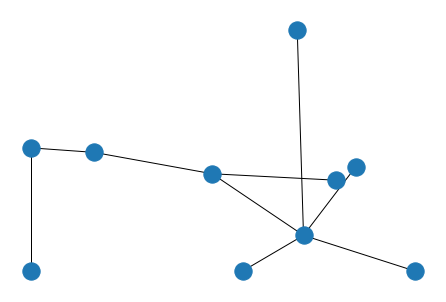

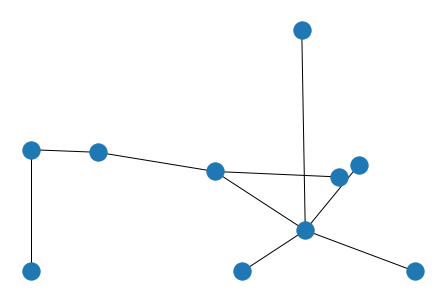

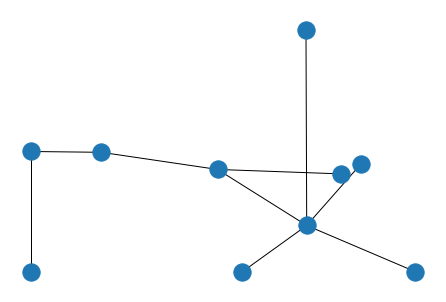

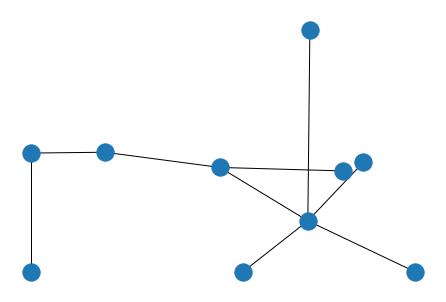

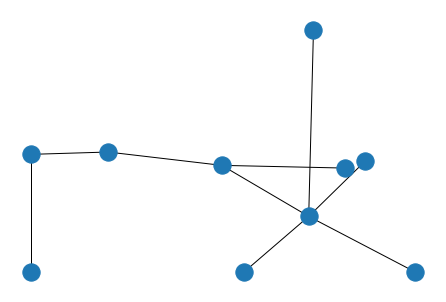

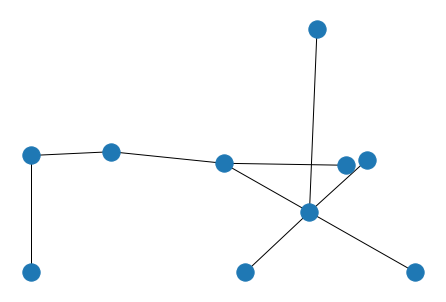

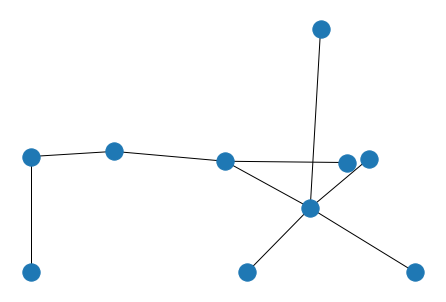

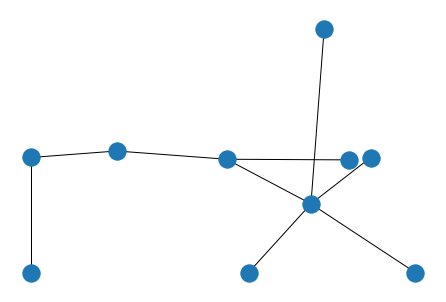

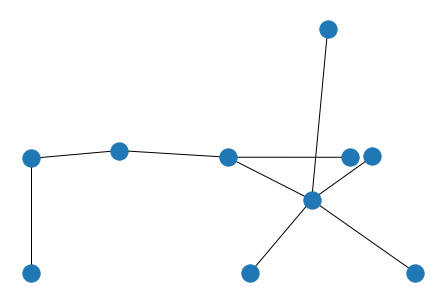

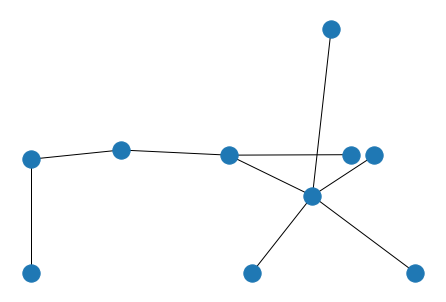

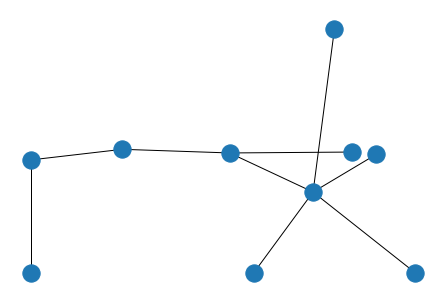

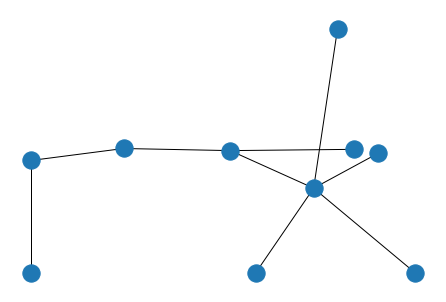

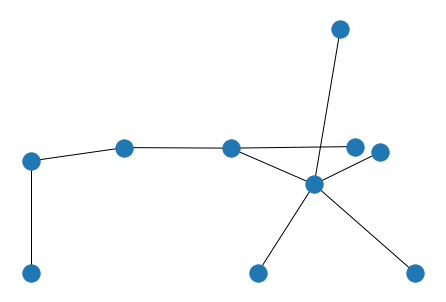

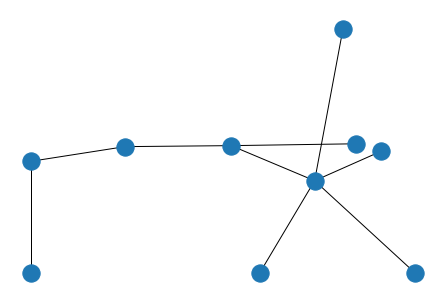

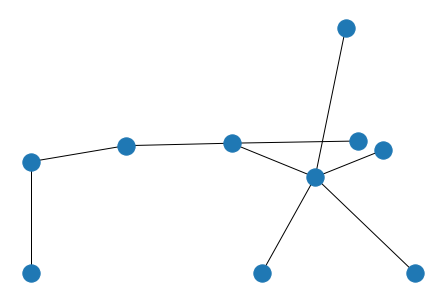

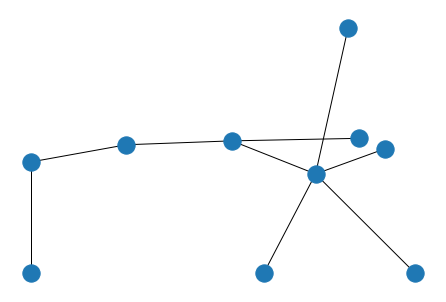

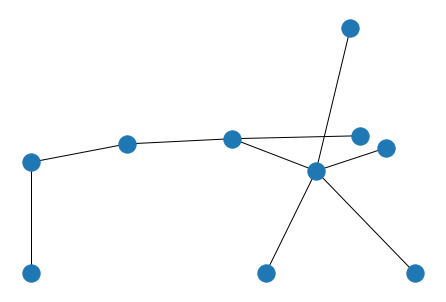

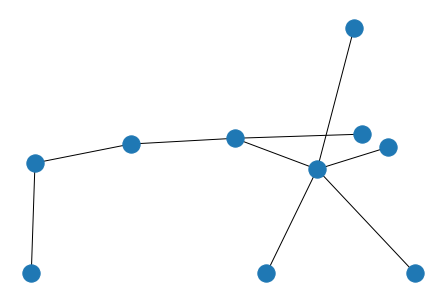

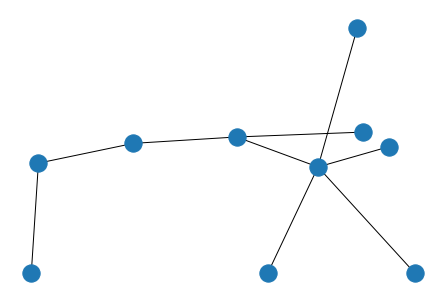

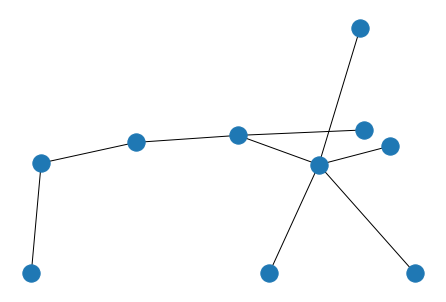

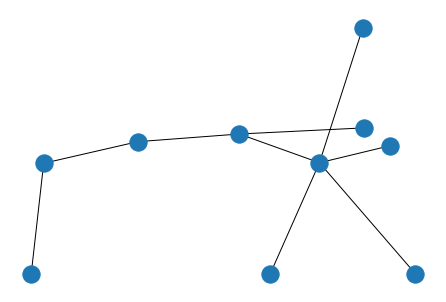

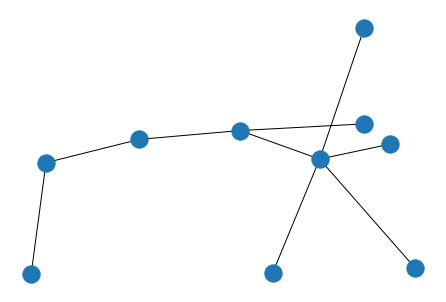

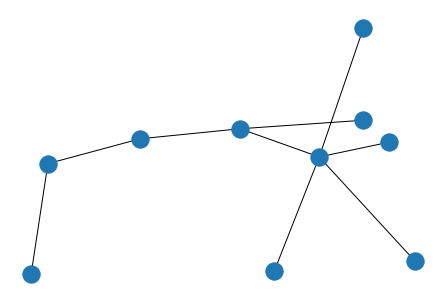

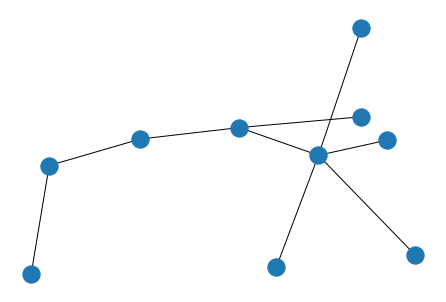

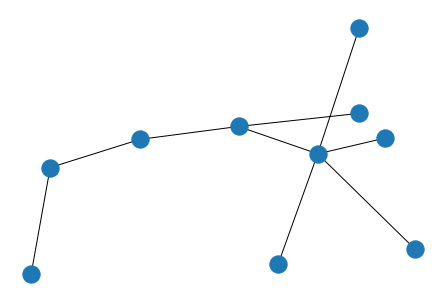

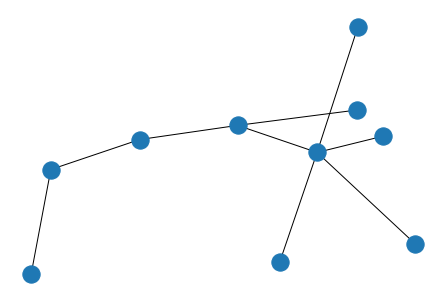

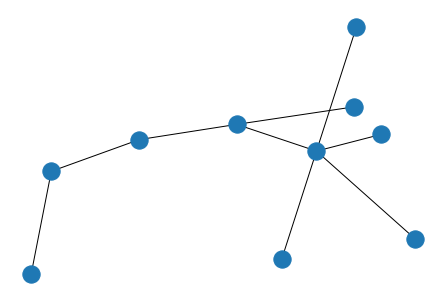

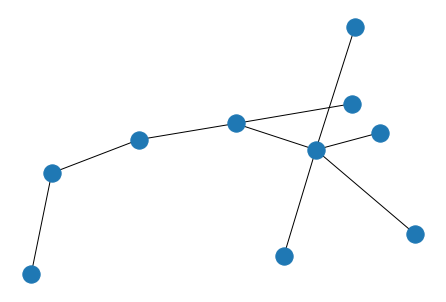

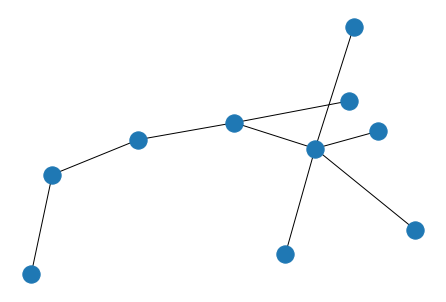

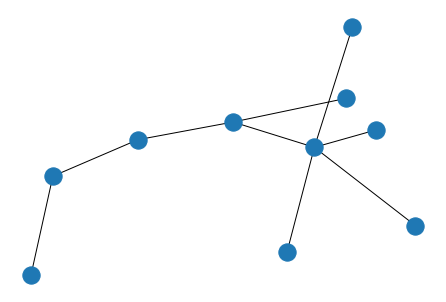

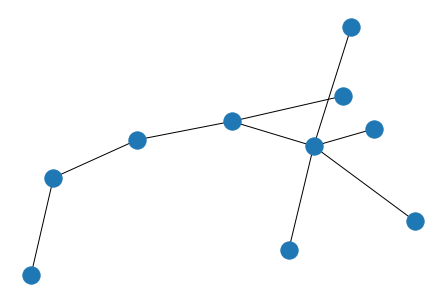

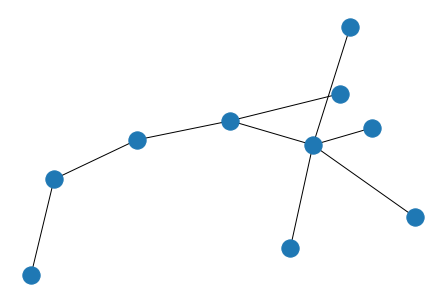

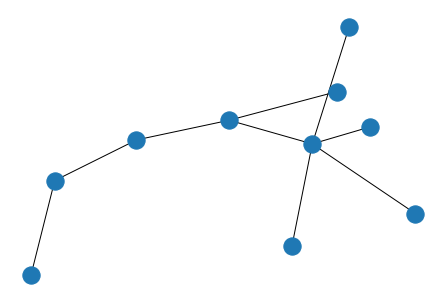

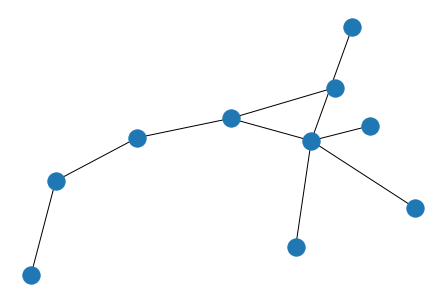

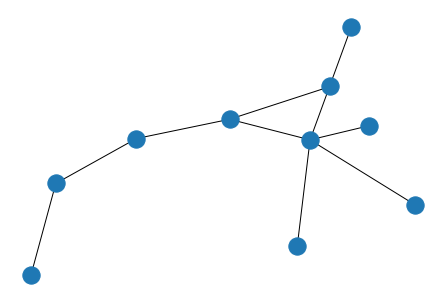

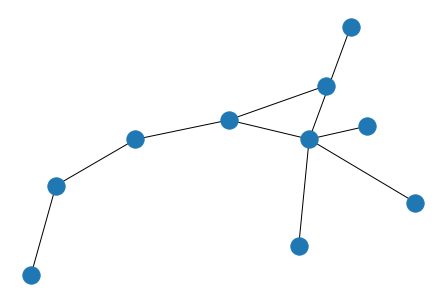

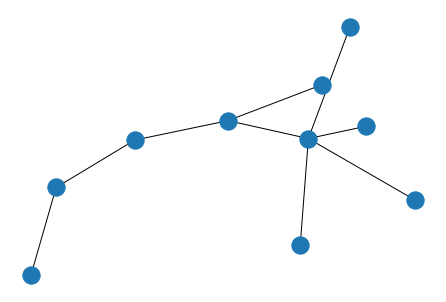

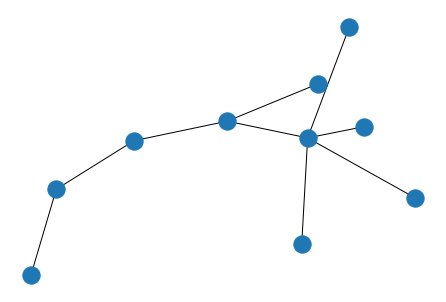

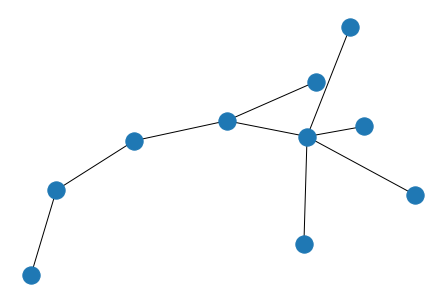

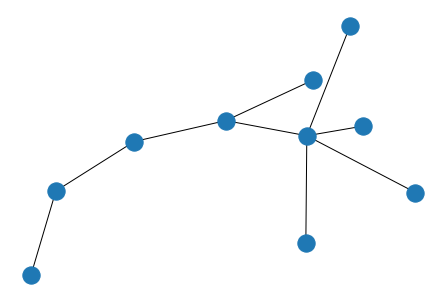

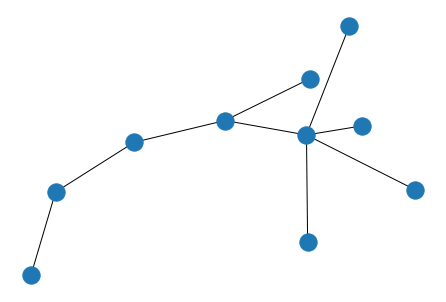

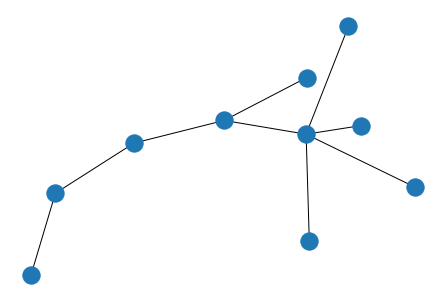

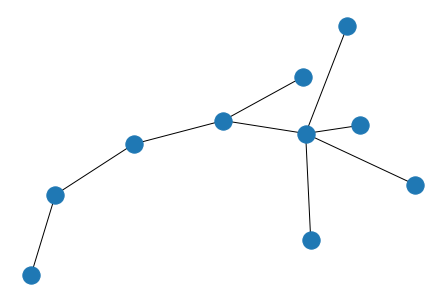

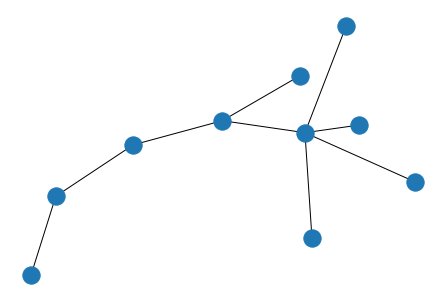

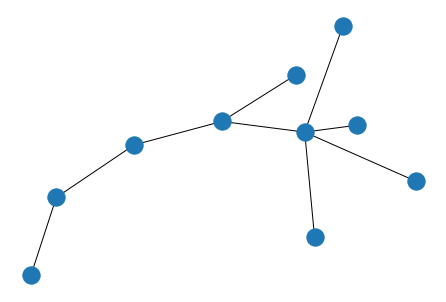

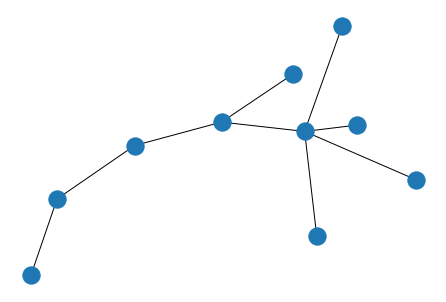

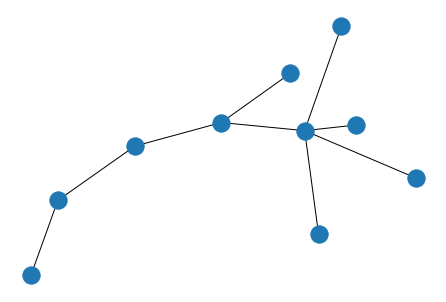

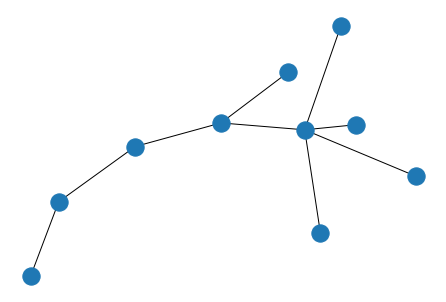

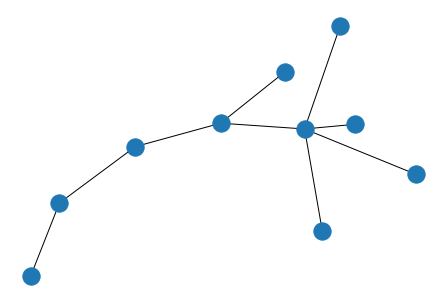

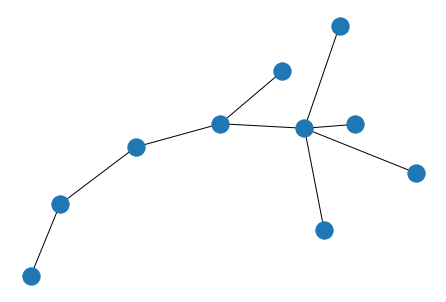

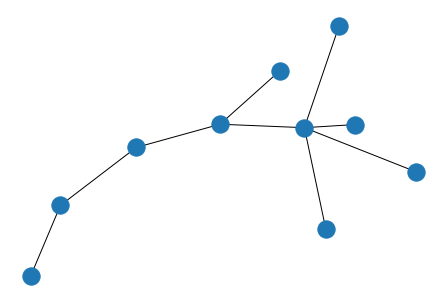

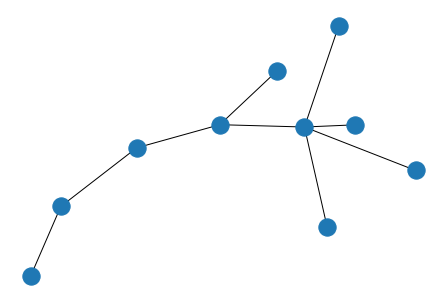

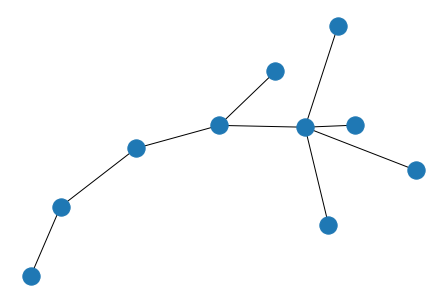

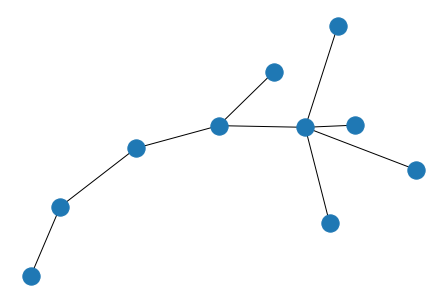

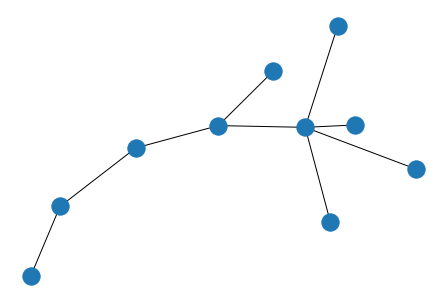

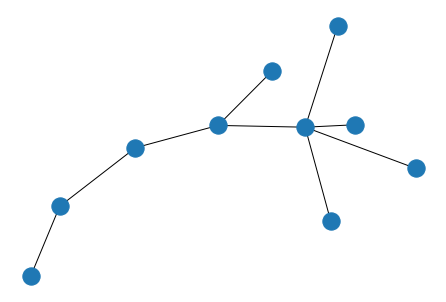

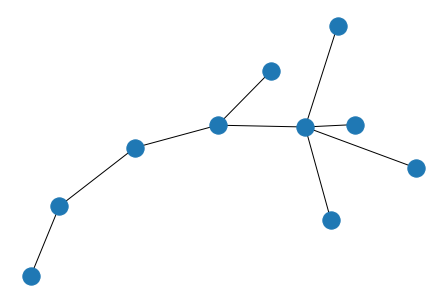

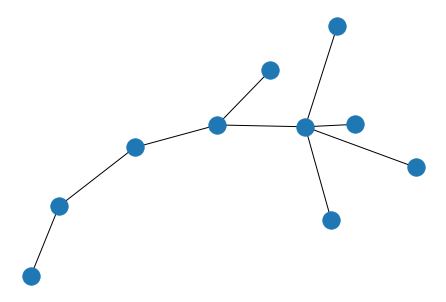

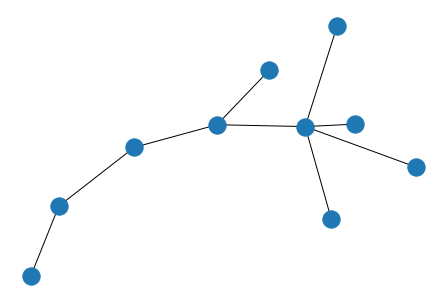

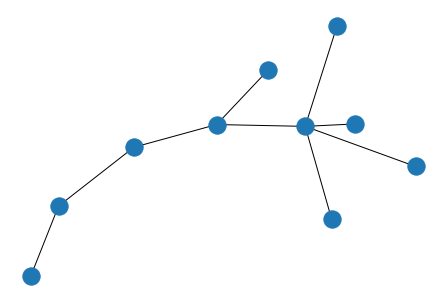

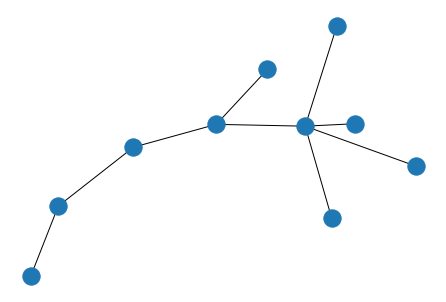

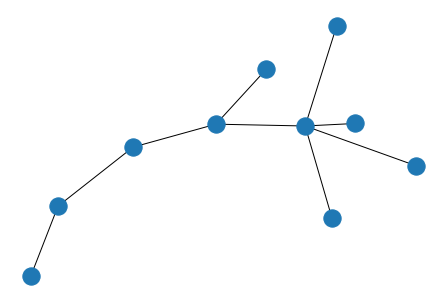

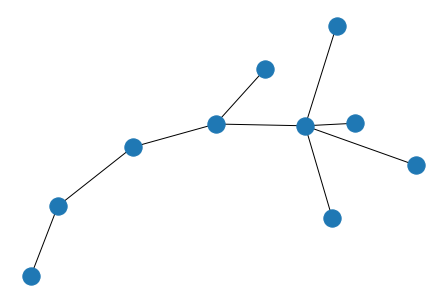

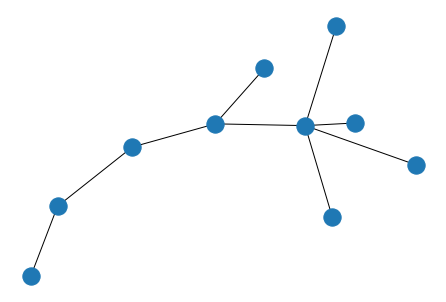

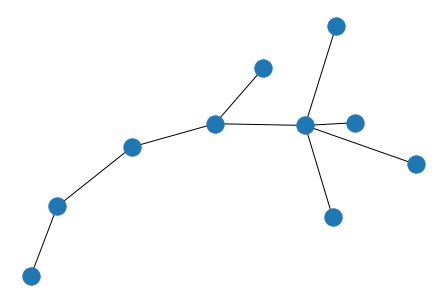

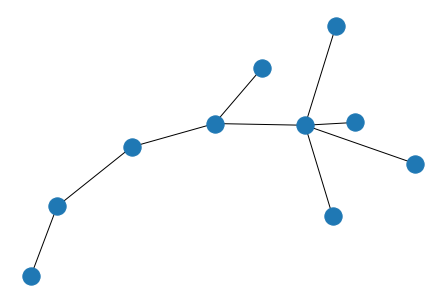

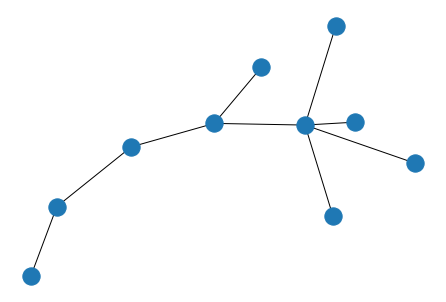

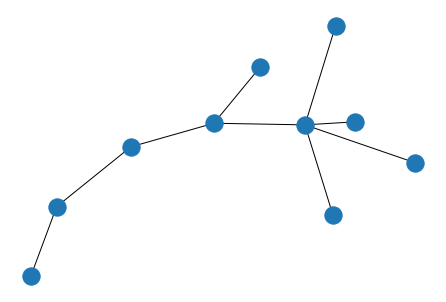

In [28]:
# 2 convolutional layer with shared parameter
data.x = generate_randPos(10)
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, output, f'test_traingraph2_share/epoch_{i}.png')

0 tensor(2.0321, grad_fn=<AddBackward0>)
1000 tensor(1.6256, grad_fn=<AddBackward0>)
2000 tensor(1.3987, grad_fn=<AddBackward0>)
3000 tensor(1.2534, grad_fn=<AddBackward0>)
4000 tensor(1.1613, grad_fn=<AddBackward0>)
5000 tensor(1.0822, grad_fn=<AddBackward0>)
6000 tensor(0.9931, grad_fn=<AddBackward0>)
7000 tensor(0.8315, grad_fn=<AddBackward0>)
8000 tensor(0.7226, grad_fn=<AddBackward0>)
9000 tensor(0.6602, grad_fn=<AddBackward0>)
10000 tensor(0.6171, grad_fn=<AddBackward0>)
11000 tensor(0.5887, grad_fn=<AddBackward0>)
12000 tensor(0.5708, grad_fn=<AddBackward0>)
13000 tensor(0.5586, grad_fn=<AddBackward0>)
14000 tensor(0.5493, grad_fn=<AddBackward0>)
15000 tensor(0.5419, grad_fn=<AddBackward0>)
16000 tensor(0.5358, grad_fn=<AddBackward0>)
17000 tensor(0.5305, grad_fn=<AddBackward0>)
18000 tensor(0.5258, grad_fn=<AddBackward0>)
19000 tensor(0.5211, grad_fn=<AddBackward0>)
20000 tensor(0.5163, grad_fn=<AddBackward0>)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21000 tensor(0.5117, grad_fn=<AddBackward0>)
22000 tensor(0.5073, grad_fn=<AddBackward0>)
23000 tensor(0.5028, grad_fn=<AddBackward0>)
24000 tensor(0.4979, grad_fn=<AddBackward0>)
25000 tensor(0.4927, grad_fn=<AddBackward0>)
26000 tensor(0.4871, grad_fn=<AddBackward0>)
27000 tensor(0.4811, grad_fn=<AddBackward0>)
28000 tensor(0.4746, grad_fn=<AddBackward0>)
29000 tensor(0.4682, grad_fn=<AddBackward0>)
30000 tensor(0.4626, grad_fn=<AddBackward0>)
31000 tensor(0.4570, grad_fn=<AddBackward0>)
32000 tensor(0.4517, grad_fn=<AddBackward0>)
33000 tensor(0.4465, grad_fn=<AddBackward0>)
34000 tensor(0.4413, grad_fn=<AddBackward0>)
35000 tensor(0.4362, grad_fn=<AddBackward0>)
36000 tensor(0.4311, grad_fn=<AddBackward0>)
37000 tensor(0.4260, grad_fn=<AddBackward0>)
38000 tensor(0.4209, grad_fn=<AddBackward0>)
39000 tensor(0.4156, grad_fn=<AddBackward0>)
40000 tensor(0.4102, grad_fn=<AddBackward0>)
41000 tensor(0.4045, grad_fn=<AddBackward0>)
42000 tensor(0.3985, grad_fn=<AddBackward0>)
43000 tens

KeyboardInterrupt: 

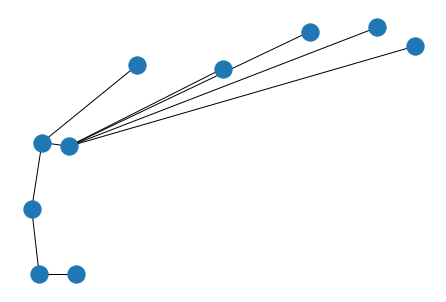

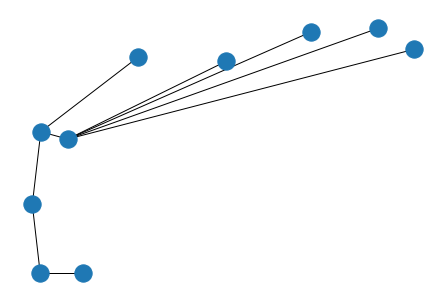

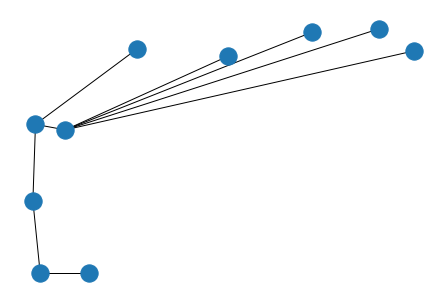

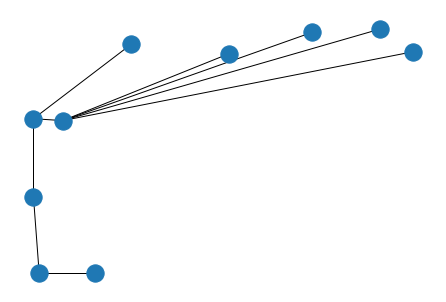

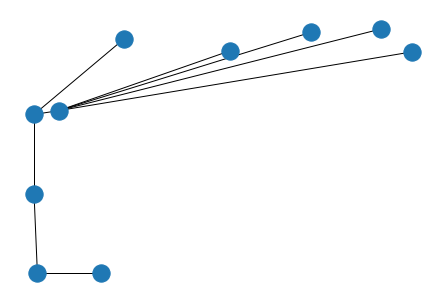

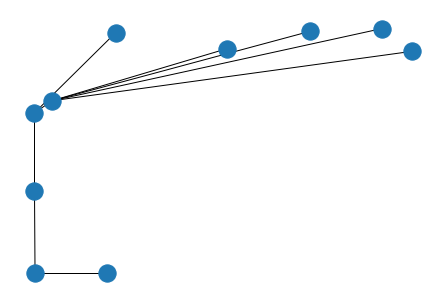

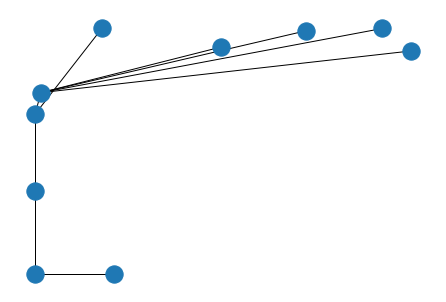

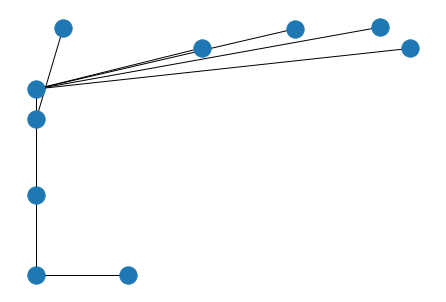

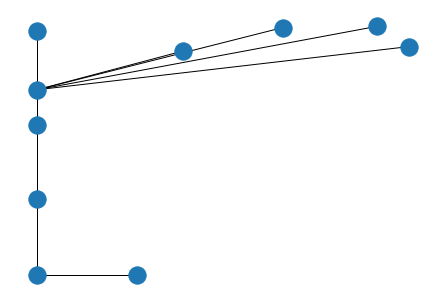

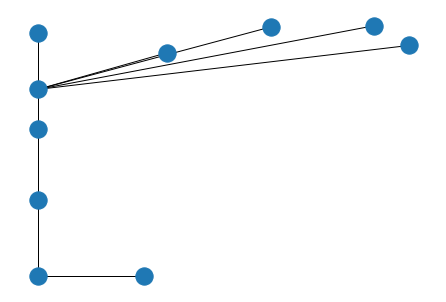

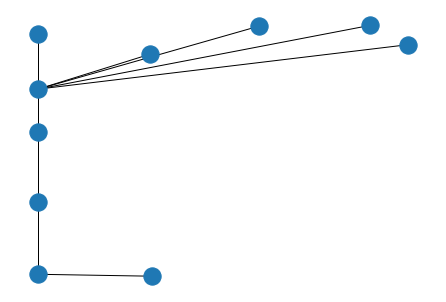

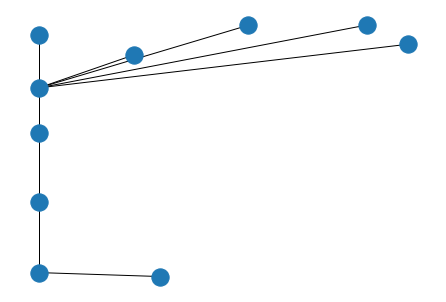

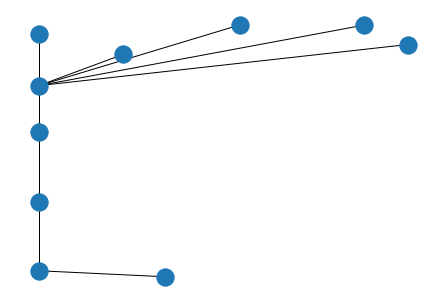

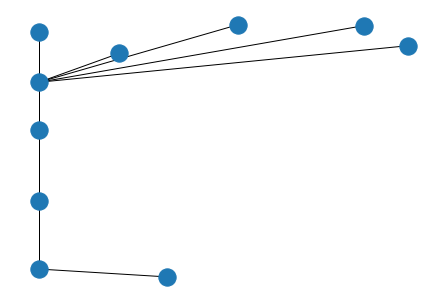

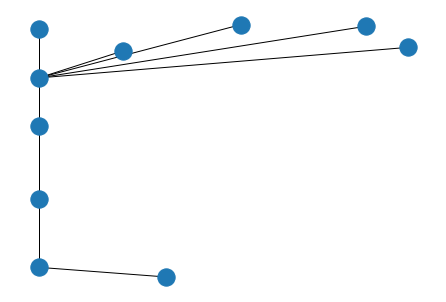

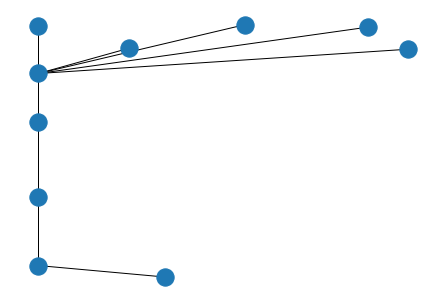

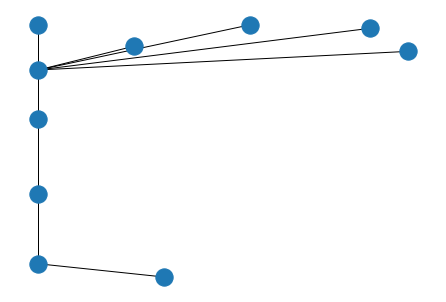

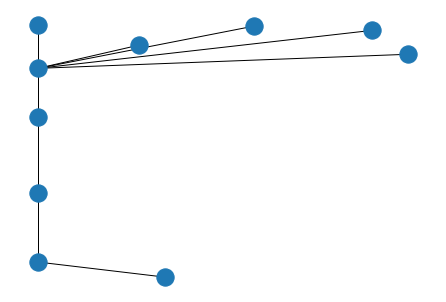

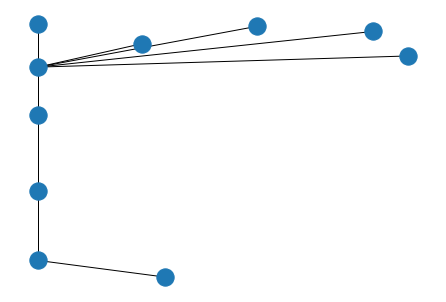

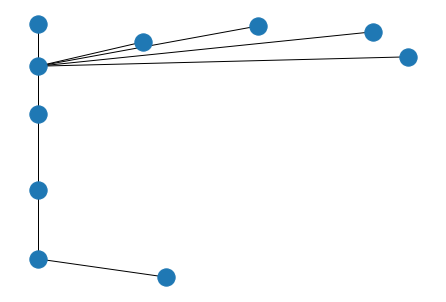

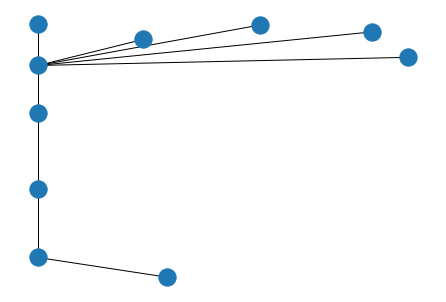

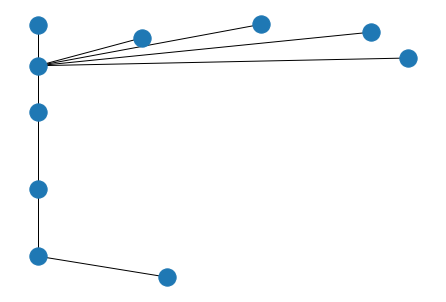

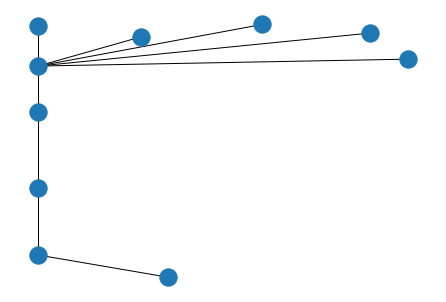

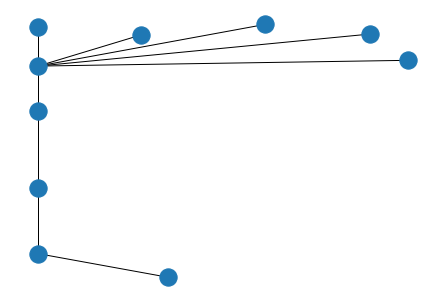

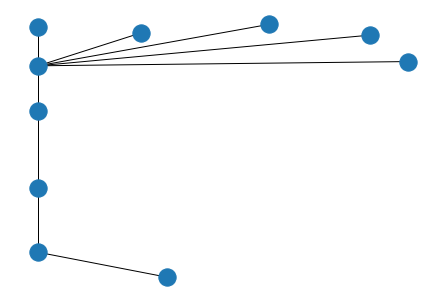

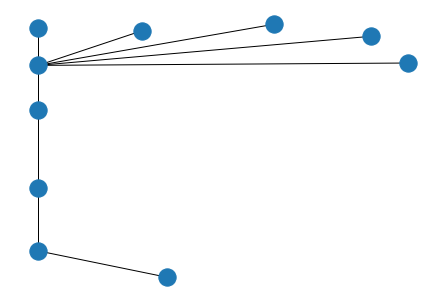

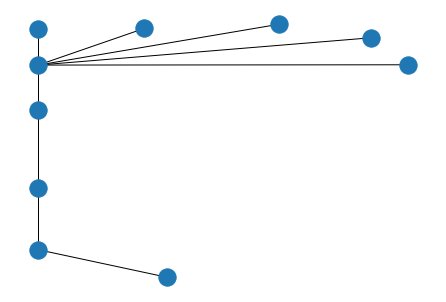

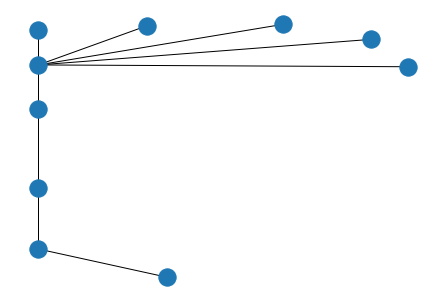

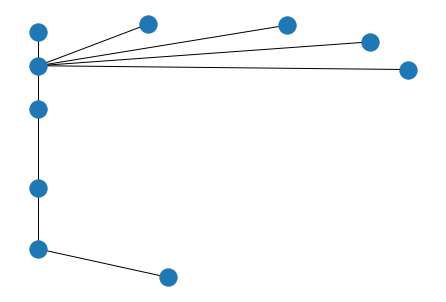

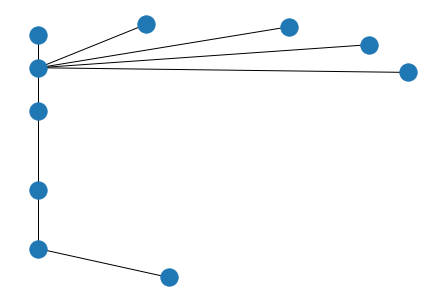

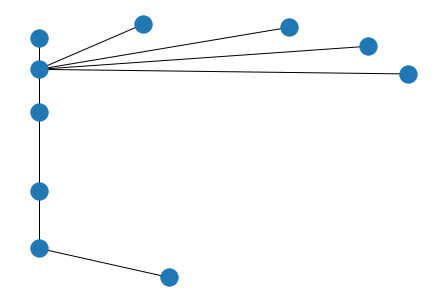

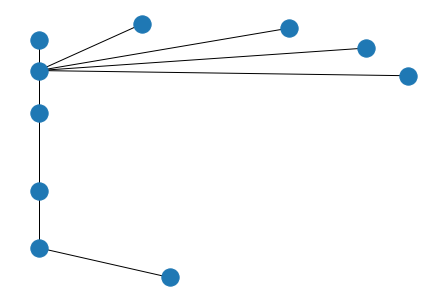

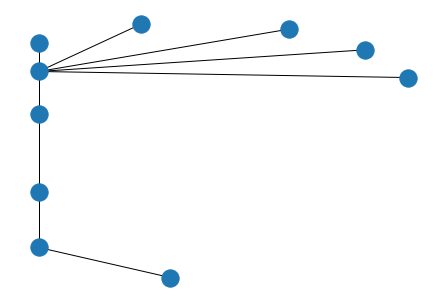

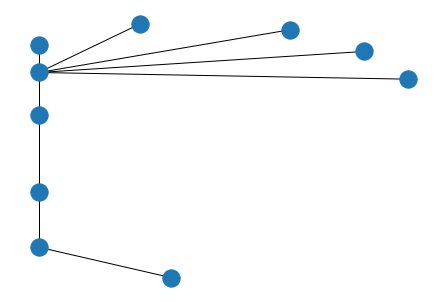

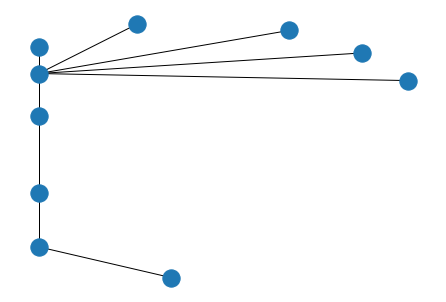

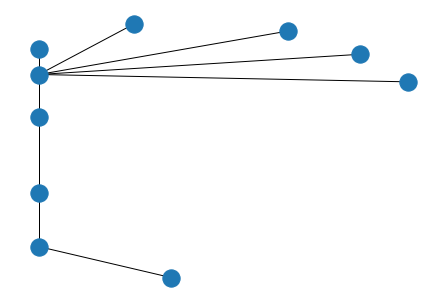

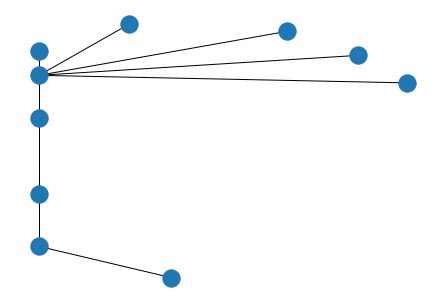

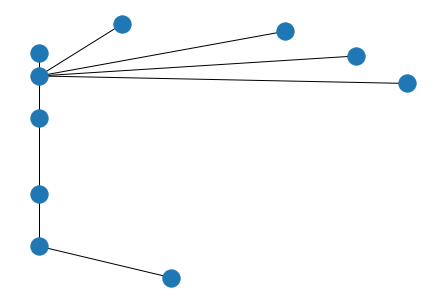

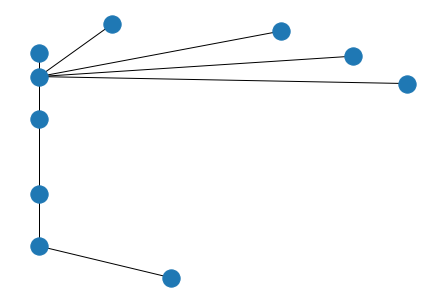

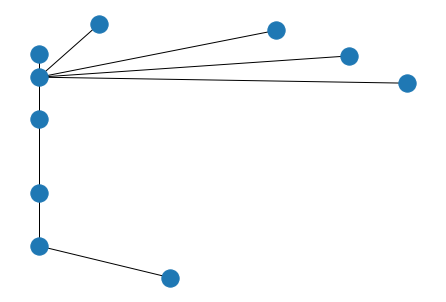

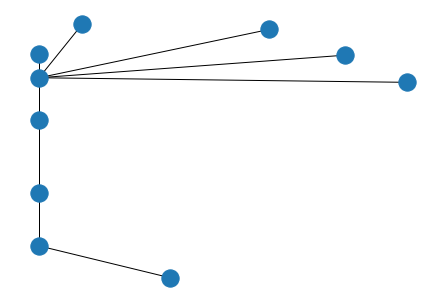

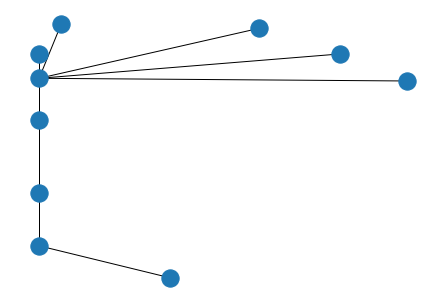

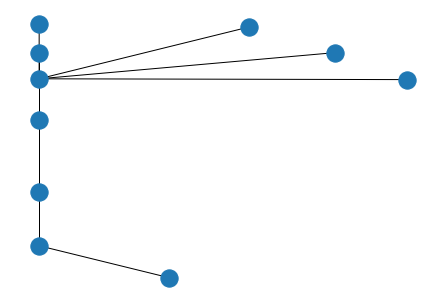

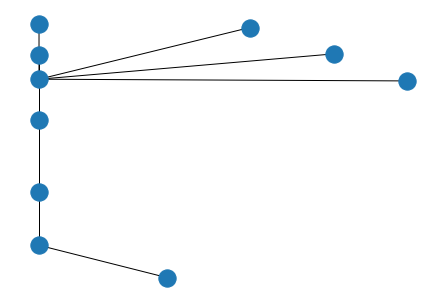

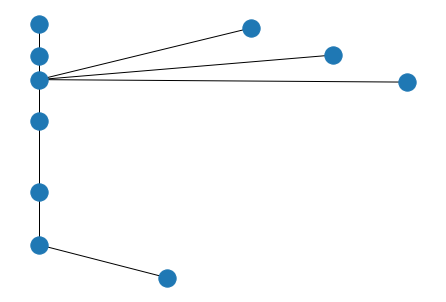

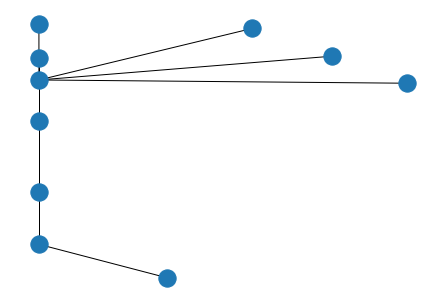

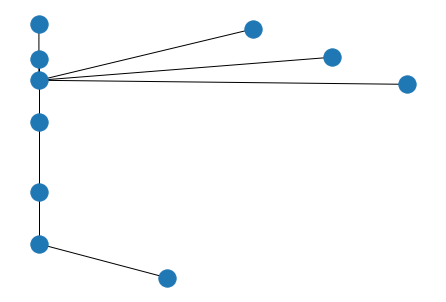

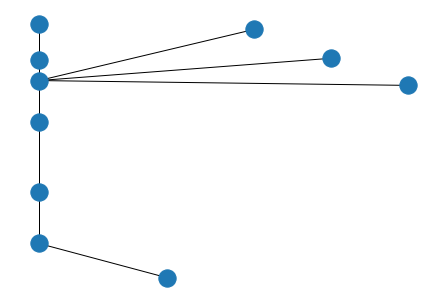

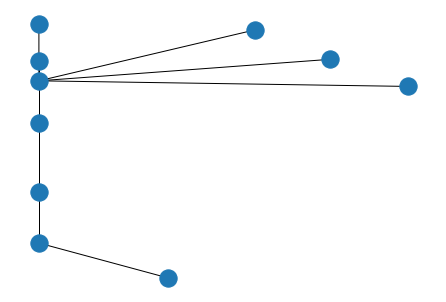

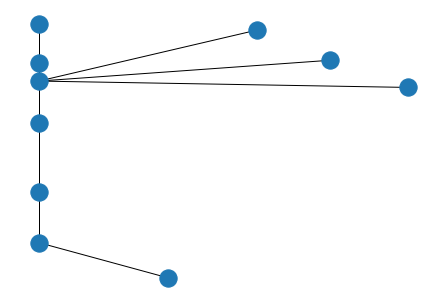

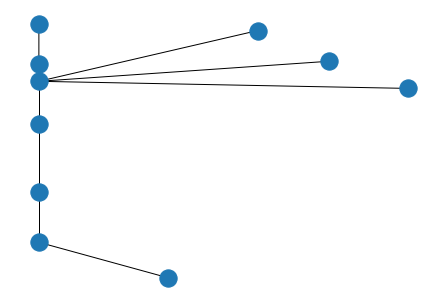

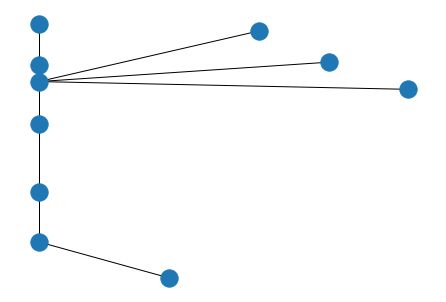

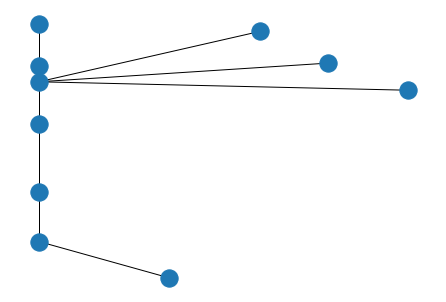

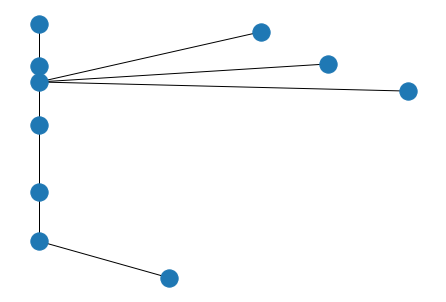

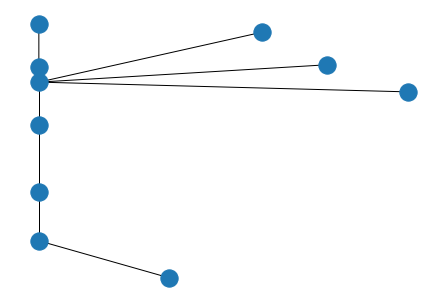

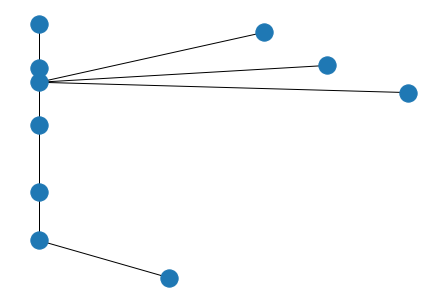

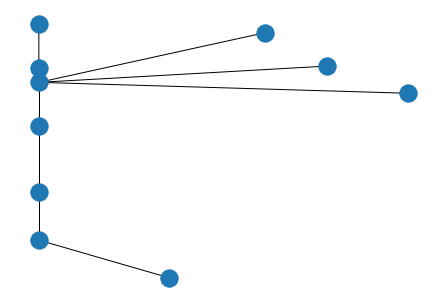

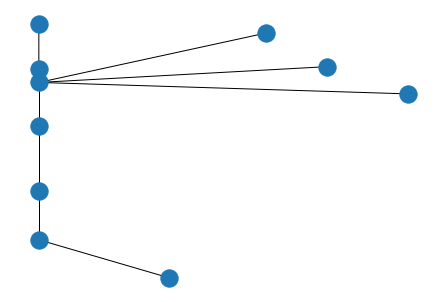

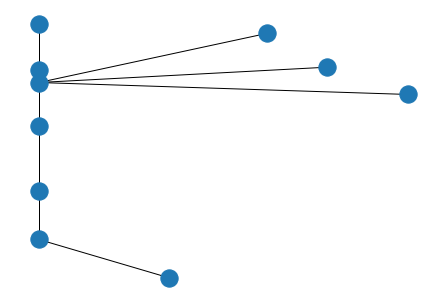

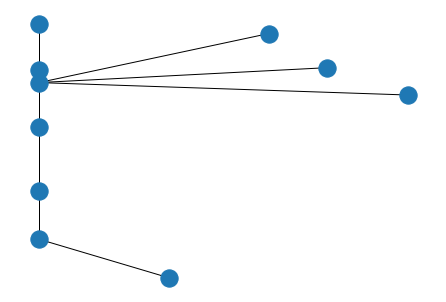

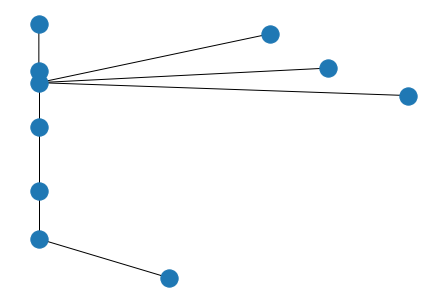

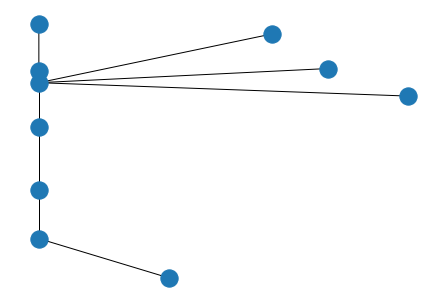

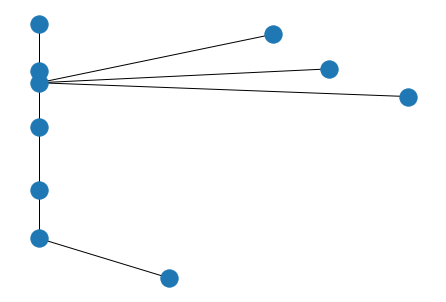

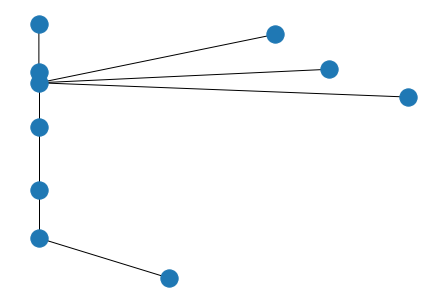

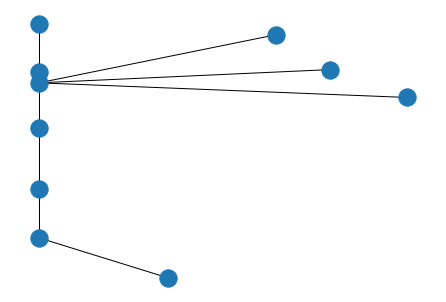

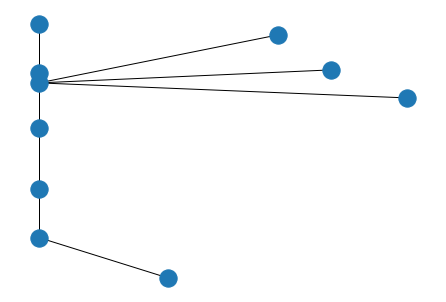

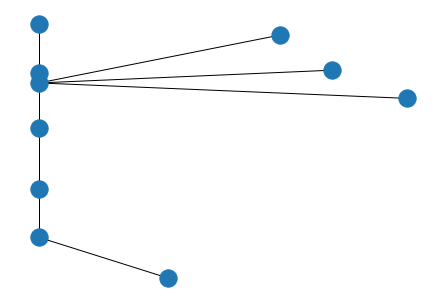

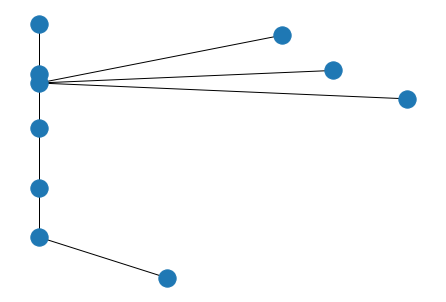

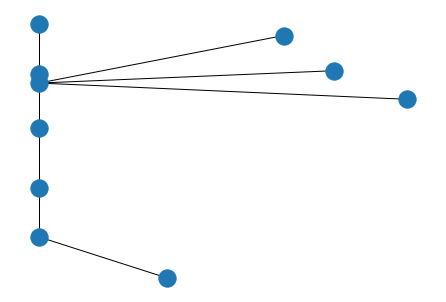

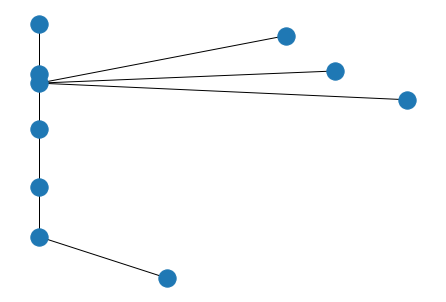

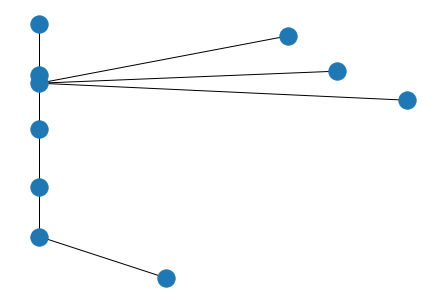

In [33]:
#3 convolutional layer with shared parameter
data.x = generate_randPos(10)
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, output, f'test_traingraph3_share/epoch_{i}.png')

0 tensor(350.3214, grad_fn=<AddBackward0>)
1000 tensor(171.4642, grad_fn=<AddBackward0>)
2000 tensor(90.4495, grad_fn=<AddBackward0>)
3000 tensor(48.1796, grad_fn=<AddBackward0>)
4000 tensor(24.5913, grad_fn=<AddBackward0>)
5000 tensor(11.5679, grad_fn=<AddBackward0>)
6000 tensor(4.9026, grad_fn=<AddBackward0>)
7000 tensor(2.1121, grad_fn=<AddBackward0>)
8000 tensor(1.1670, grad_fn=<AddBackward0>)
9000 tensor(0.7093, grad_fn=<AddBackward0>)
10000 tensor(0.4756, grad_fn=<AddBackward0>)
11000 tensor(0.3785, grad_fn=<AddBackward0>)
12000 tensor(0.3318, grad_fn=<AddBackward0>)
13000 tensor(0.2951, grad_fn=<AddBackward0>)
14000 tensor(0.2565, grad_fn=<AddBackward0>)
15000 tensor(0.2225, grad_fn=<AddBackward0>)
16000 tensor(0.1955, grad_fn=<AddBackward0>)
17000 tensor(0.1712, grad_fn=<AddBackward0>)
18000 tensor(0.1501, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

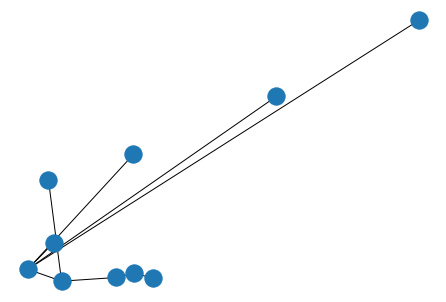

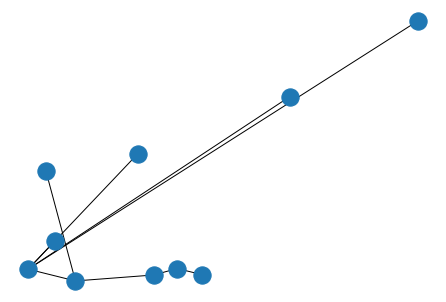

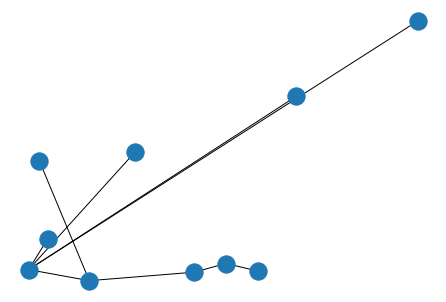

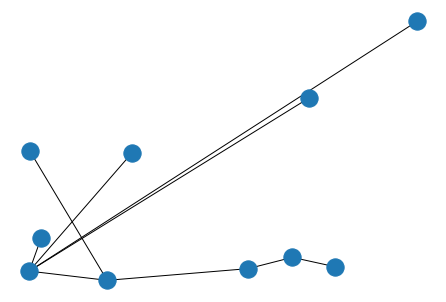

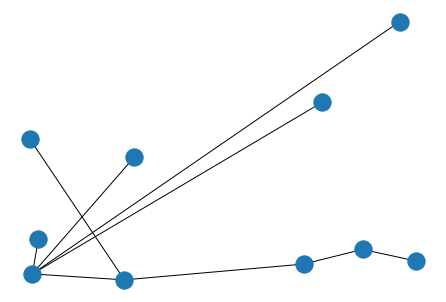

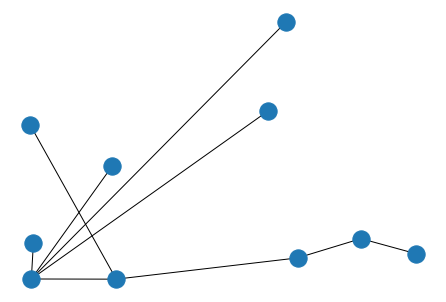

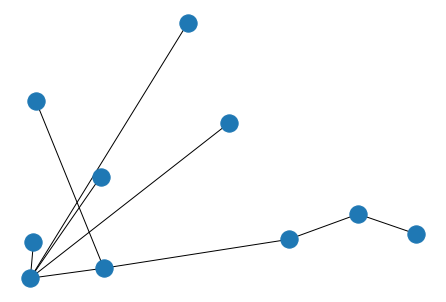

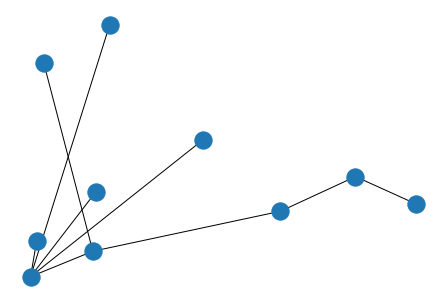

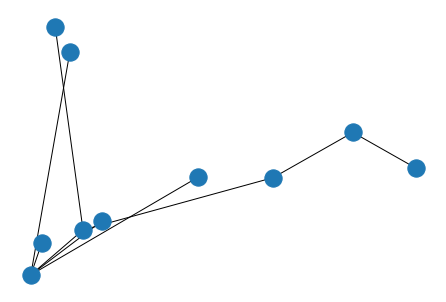

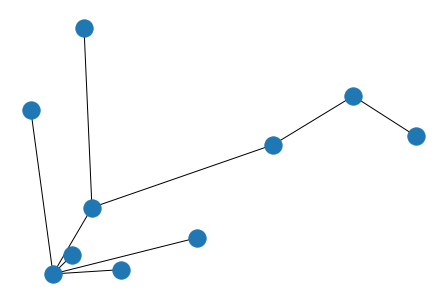

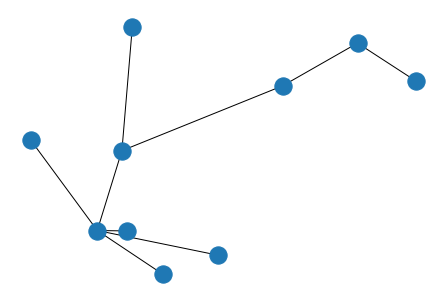

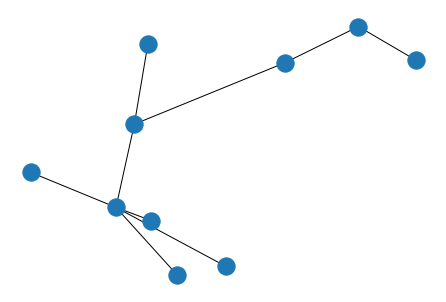

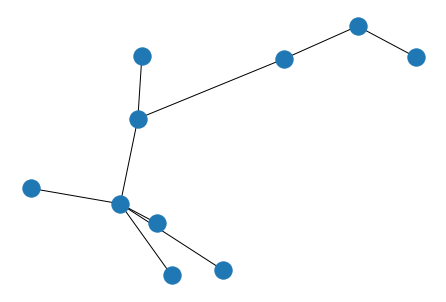

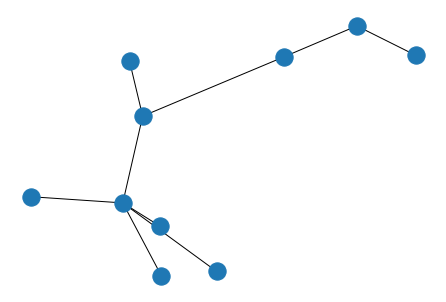

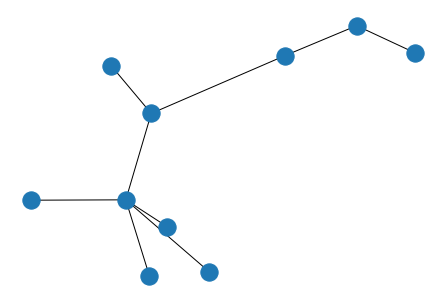

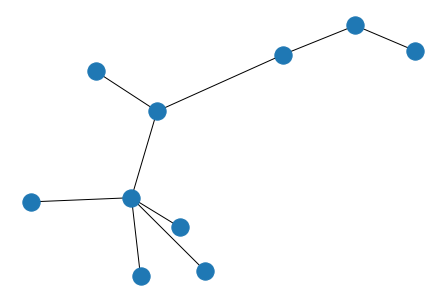

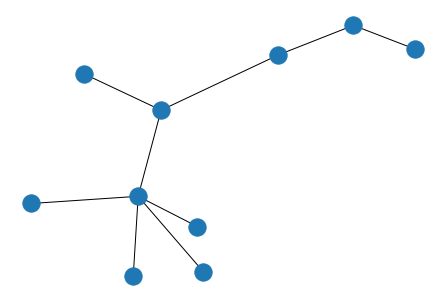

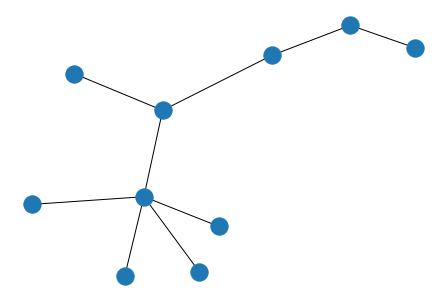

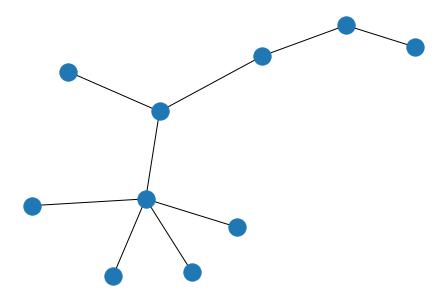

In [39]:
# 5 convolutional layer with shared parameters in layer 2-4 and no activation for the output layer
data.x = generate_randPos(10)
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, output, f'test_traingraph5_share_no/epoch_{i}.png')

In [60]:
ngraph = 500
ngraph_size = [random.randint(5,20) for i in range(ngraph)]
data_list = []
for i in range(ngraph):
    G, data = generate_graph(ngraph_size[i])
    data_list.append(data)
loader = DataLoader(data_list,shuffle=True)

0 4009147.639502082
10 2526866.5440970776
20 1587840.7430589756
30 986114.7255104957
40 609054.7809149033
50 373734.0133886881
60 227406.89848613547
70 138633.29410516287
80 84707.23569982612
90 51891.44180102825
100 31546.67363370359
110 19452.957718991816
120 12111.525567079902
130 7639.390286156058
140 4882.068206920266
150 3175.687160931468
160 2117.6564986326694
170 1425.3364440057278
180 979.510705548048
190 679.5127560111284
200 486.14279851734636


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


210 366.9861674230099
220 286.6863157205582
230 228.15379852724075
240 nan
250 nan


KeyboardInterrupt: 

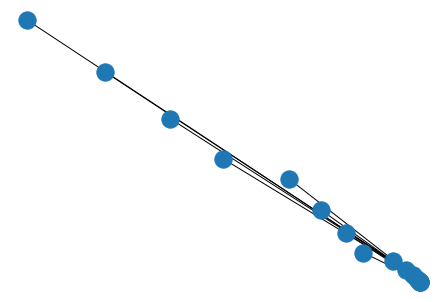

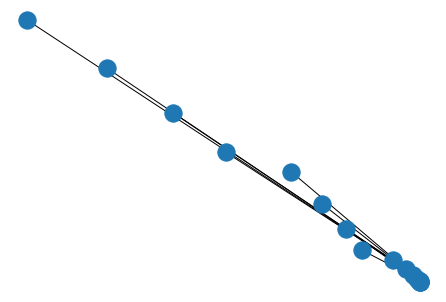

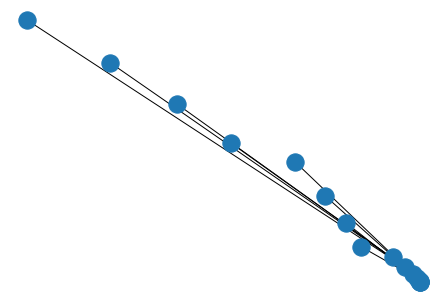

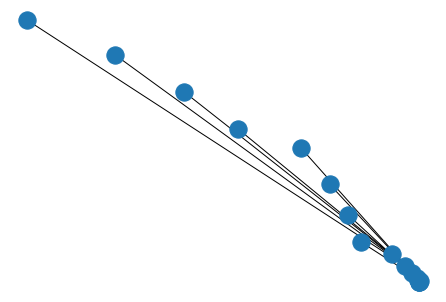

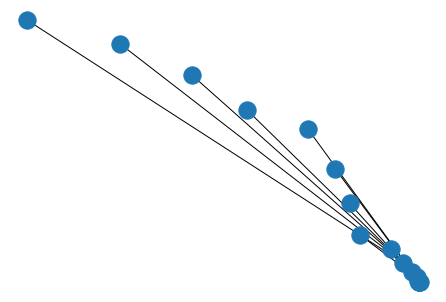

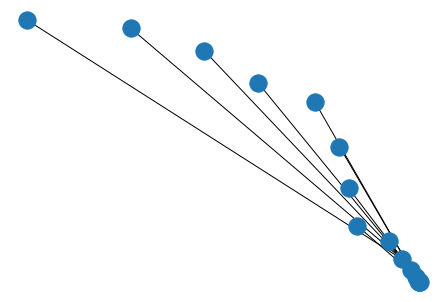

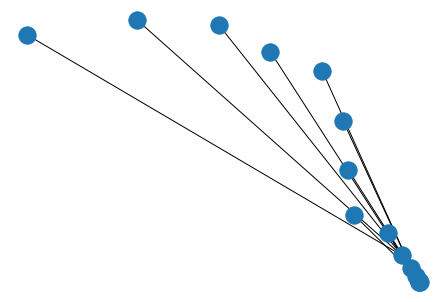

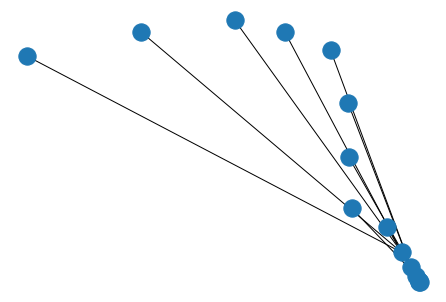

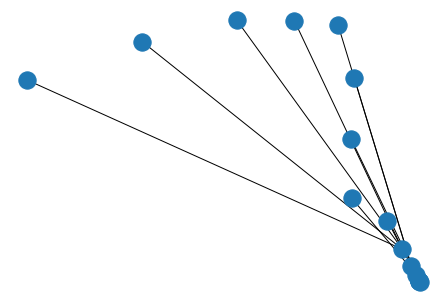

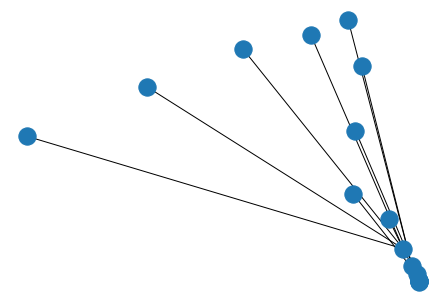

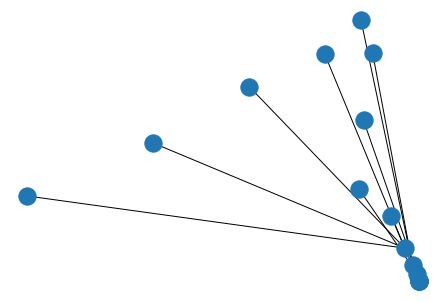

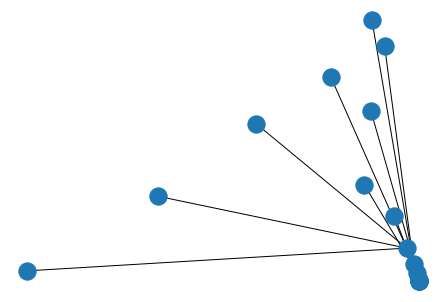

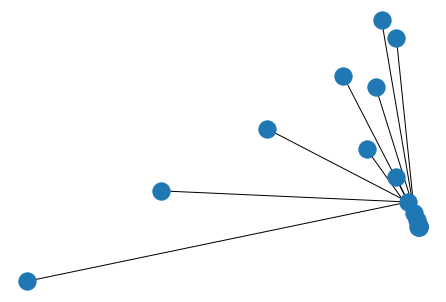

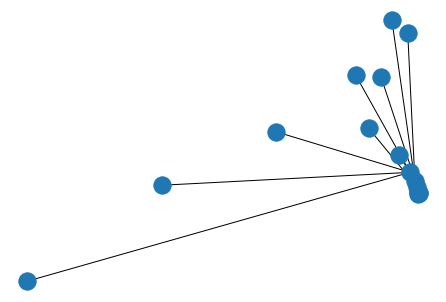

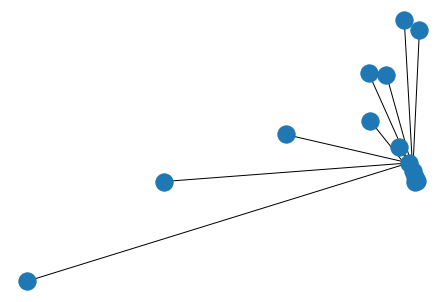

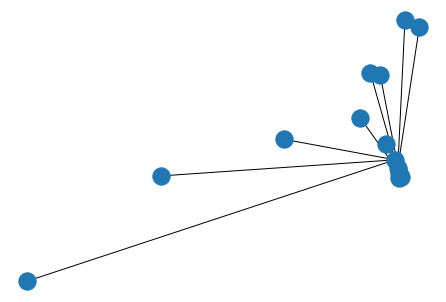

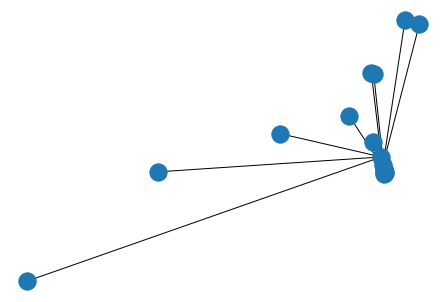

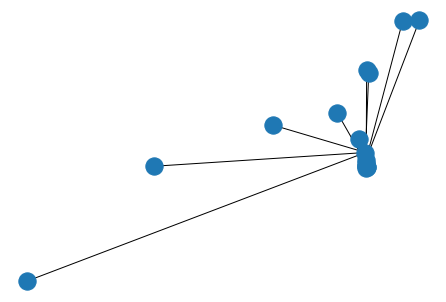

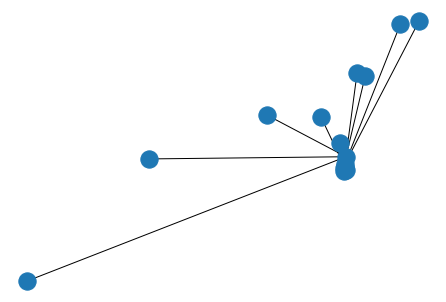

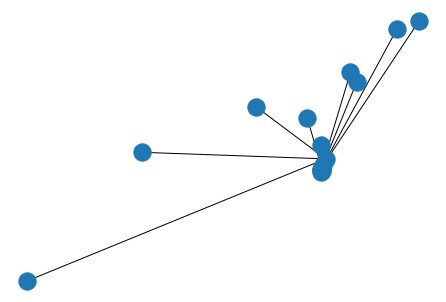

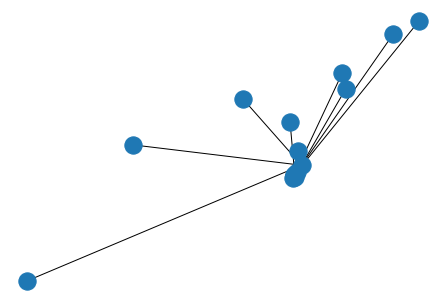

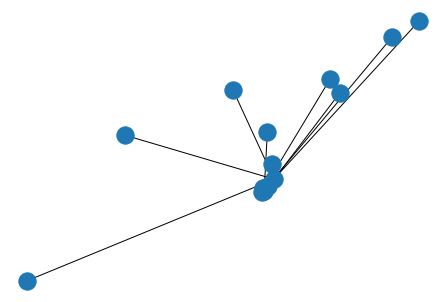

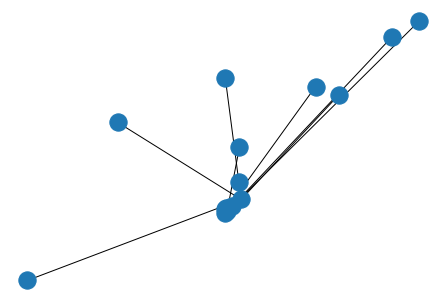

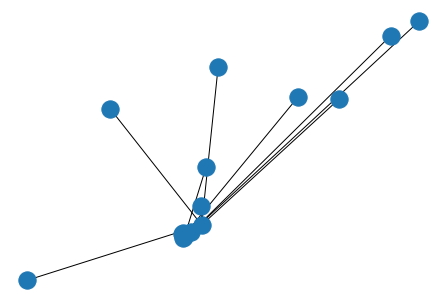

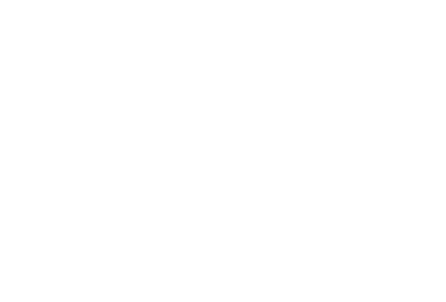

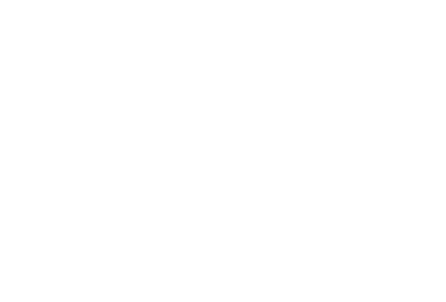

In [46]:
#traininig nn with 500 samples and evaluate with 1 specific train graph
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005, eps=1e-4)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    loss = train(model, criterion, optimizer,loader)
    loss_iters.append(loss)
    if i % 10 == 0:
        print(i,loss)
        node_pos = evaluate(model, data)
        graph_vis(G, node_pos, f'train_multiple/epoch_{i}.png')

0 1039380.725387186
10 788016.720822525
20 618990.1944436206
30 503016.5919702878
40 417364.6227500186
50 347108.5380100174
60 289813.5285447979
70 239801.82172849347
80 198300.18419020248
90 164196.14350971938
100 135917.25454013373
110 112239.67006579829
120 92556.35656474519
130 76189.01739589716
140 62208.776016133306
150 50404.108228959325
160 40395.60840461707
170 32259.257085282326
180 25659.819715739788
190 20338.750241892576
200 16144.514101589024


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


210 12881.80926932305
220 10371.640326857538
230 8418.76080297032
240 6872.341552478135
250 5607.6730762864645
260 4586.058303239018
270 3750.459026220411
280 3060.303634767145
290 2509.5402513476906
300 2065.7290856909453
310 1700.5415406478942
320 1398.7233056701123
330 1149.6303866060973
340 944.2912098745703
350 778.5955026896
360 643.090729884684
370 533.4947723340392
380 nan
390 nan
400 nan
410 nan
420 nan
430 nan


KeyboardInterrupt: 

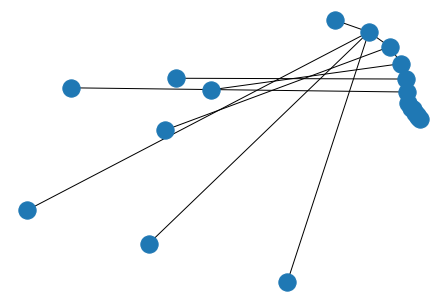

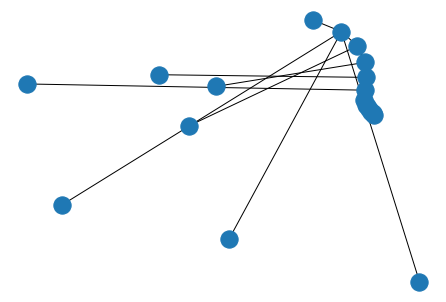

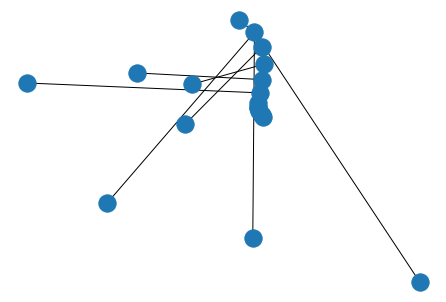

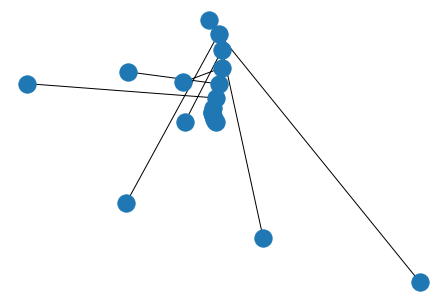

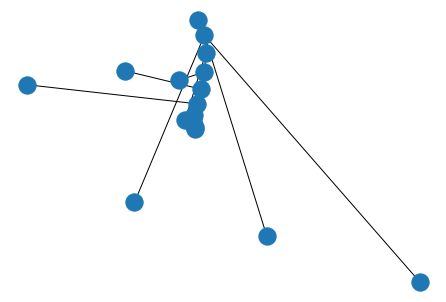

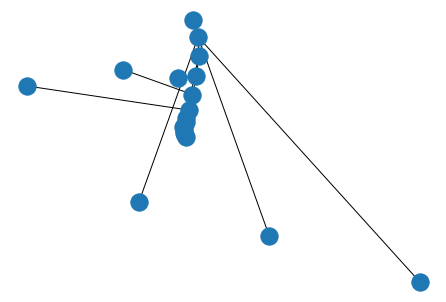

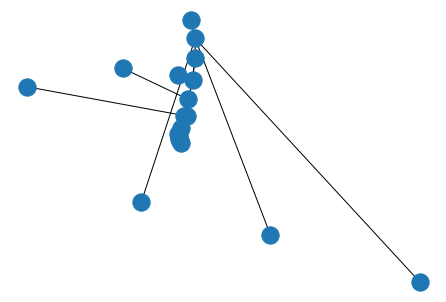

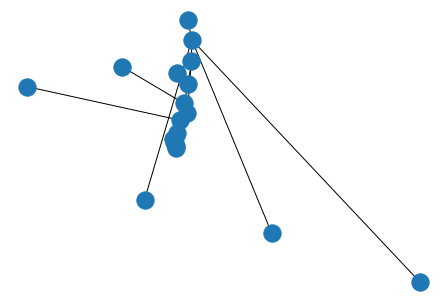

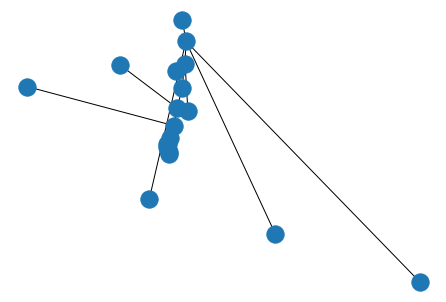

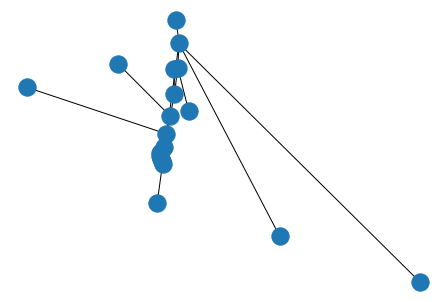

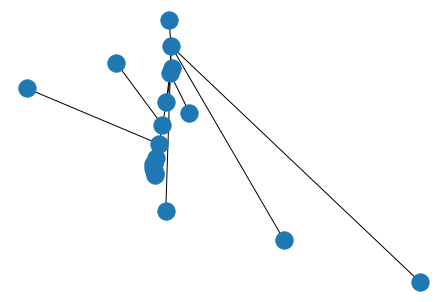

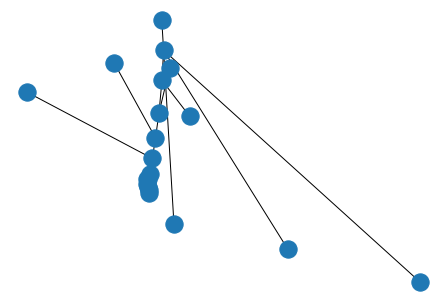

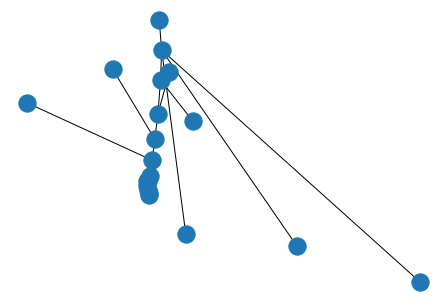

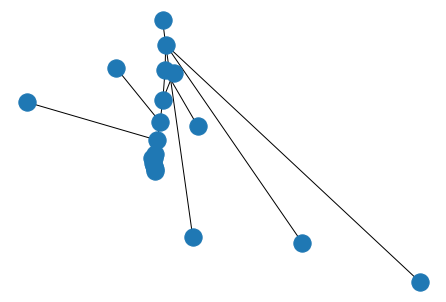

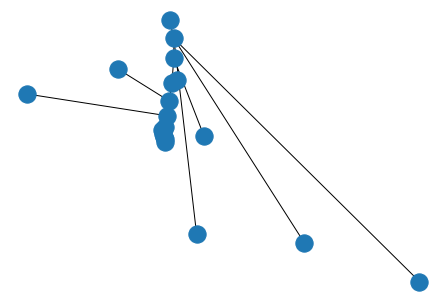

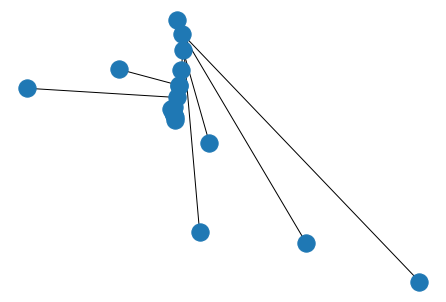

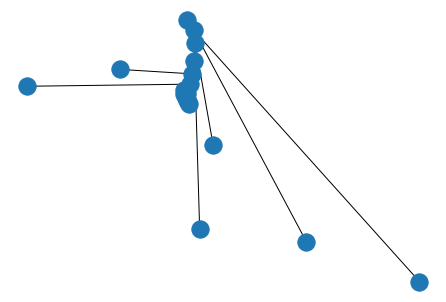

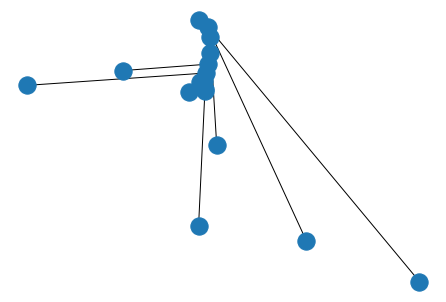

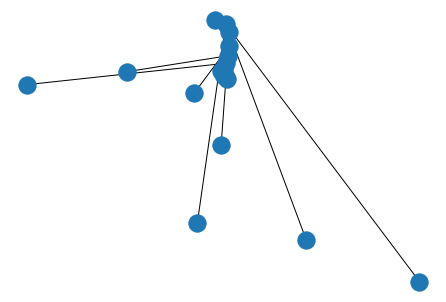

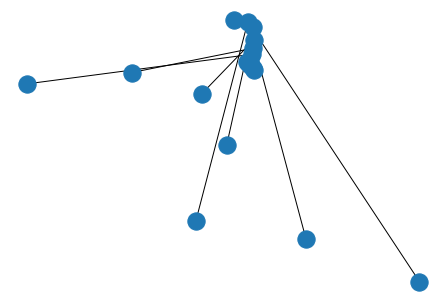

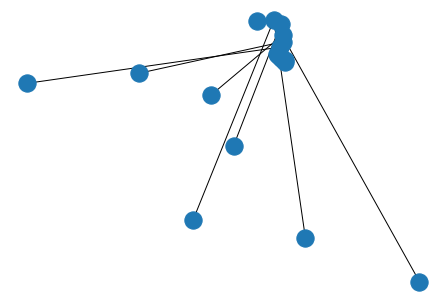

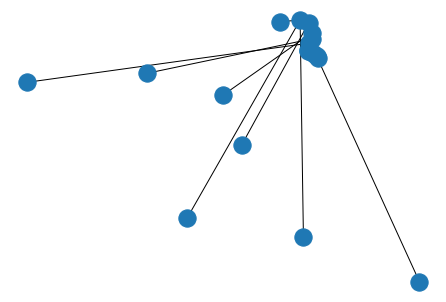

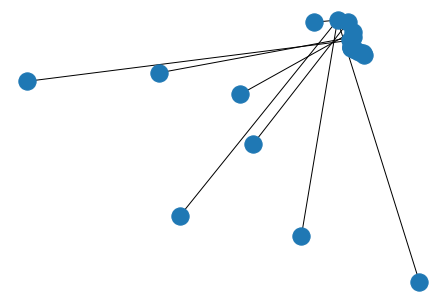

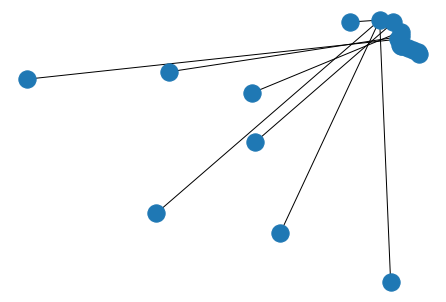

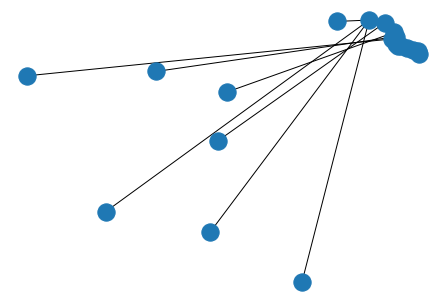

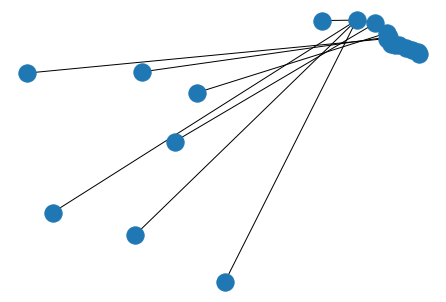

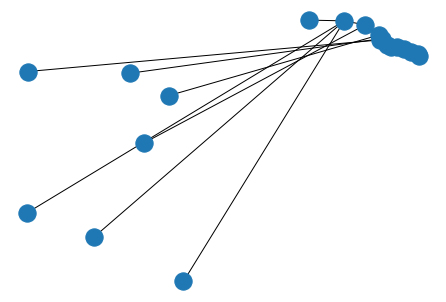

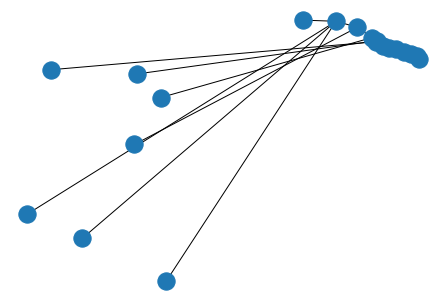

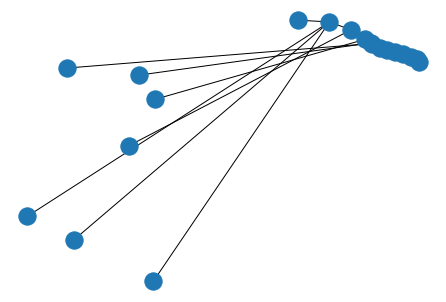

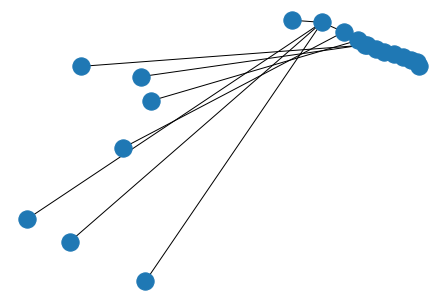

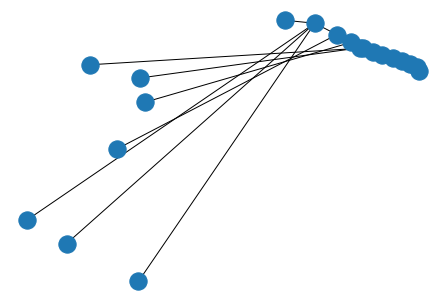

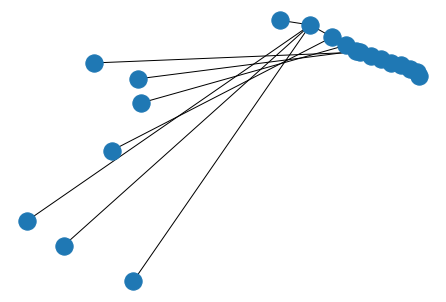

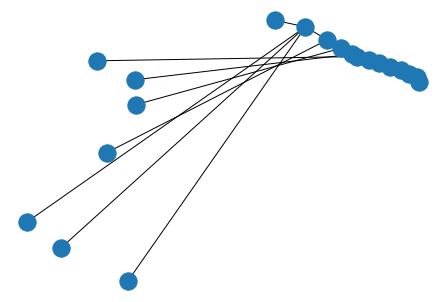

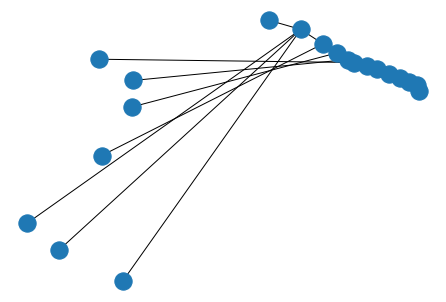

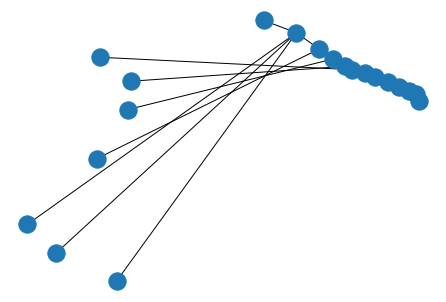

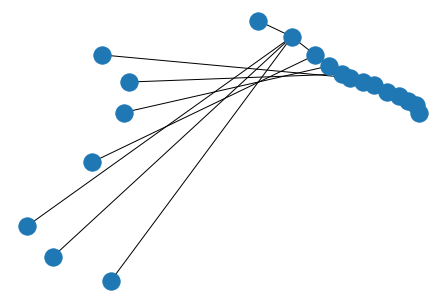

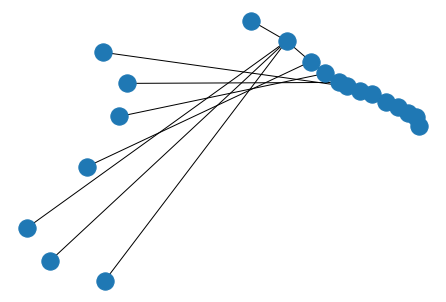

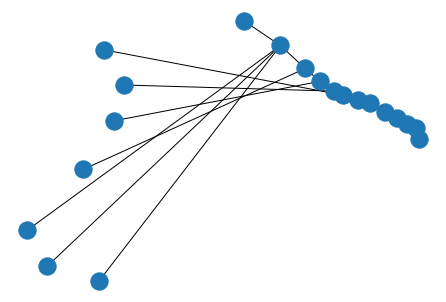

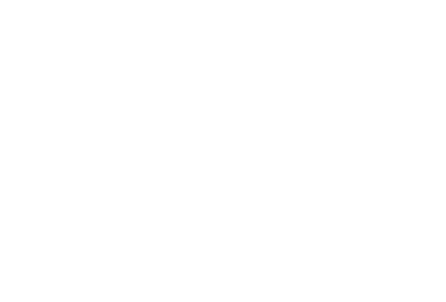

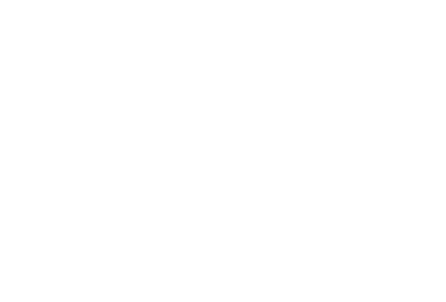

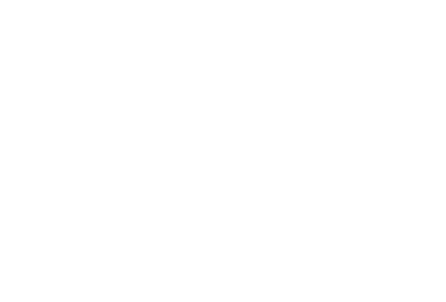

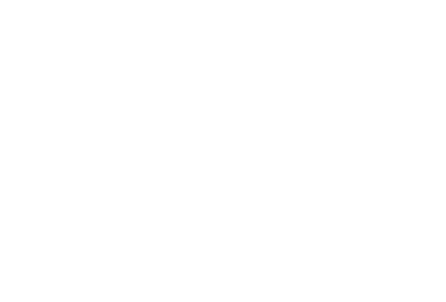

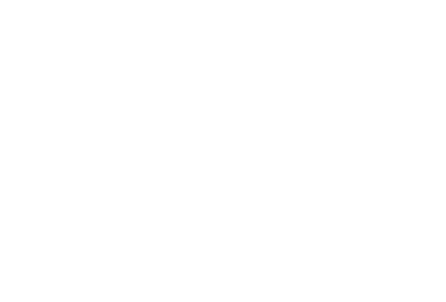

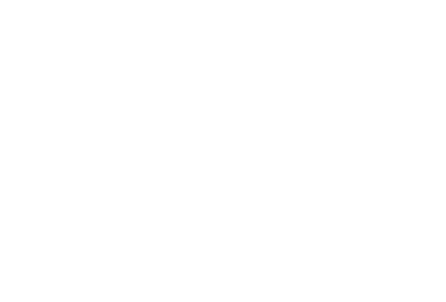

In [61]:
#traininig nn with 500 samples and evaluate with 1 specific train graph
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005, eps=1e-3)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    loss = train(model, criterion, optimizer,loader)
    loss_iters.append(loss)
    if i % 10 == 0:
        print(i,loss)
        node_pos = evaluate(model, data)
        graph_vis(G, node_pos, f'train_multiple_Adam_scale/epoch_{i}.png')